**Energy Services**

***Project 1 - South Tower Power Consumption Forecasting Using Machine Learning***

```Tomás Arêde 103239``` 

Libraries

In [1445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preparation

## Power

Import the data

In [1446]:
df_2017 = pd.read_csv(r'IST_South_Tower_2017.csv')
df_2018 = pd.read_csv(r'IST_South_Tower_2018.csv')

df = pd.concat([df_2017, df_2018], ignore_index=True)


Features Types

In [1447]:
df.dtypes

Date_start     object
Power_kW      float64
dtype: object

Dataset Table Vizualization

In [1448]:
df

Date_start    Power_kW
0         1-1-2017 0:00  100.810001
1         1-1-2017 1:00   99.054135
2         1-1-2017 2:00   98.539567
3         1-1-2017 3:00  101.435784
4         1-1-2017 4:00   98.481664
...                 ...         ...
17515  31-12-2018 19:00   97.217861
17516  31-12-2018 20:00   95.928710
17517  31-12-2018 21:00   85.652000
17518  31-12-2018 22:00   90.360675
17519  31-12-2018 23:00   81.954980

[17520 rows x 2 columns]

Data Basic Info

In [1449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date_start  17520 non-null  object 
 1   Power_kW    17520 non-null  float64
dtypes: float64(1), object(1)
memory usage: 273.9+ KB


Change Date column to datetime type and divide into different features

In [1450]:
df["Date_start"] = pd.to_datetime(df["Date_start"], dayfirst=True)

df = df.set_index('Date_start') # make 'datetime' into index

df.index = pd.to_datetime(df.index)

# features
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Day"] = df.index.day
df["Hour"] = df.index.hour

df.head()


Power_kW  Year  Month  Day  Hour
Date_start                                             
2017-01-01 00:00:00  100.810001  2017      1    1     0
2017-01-01 01:00:00   99.054135  2017      1    1     1
2017-01-01 02:00:00   98.539567  2017      1    1     2
2017-01-01 03:00:00  101.435784  2017      1    1     3
2017-01-01 04:00:00   98.481664  2017      1    1     4



**Time Plot**

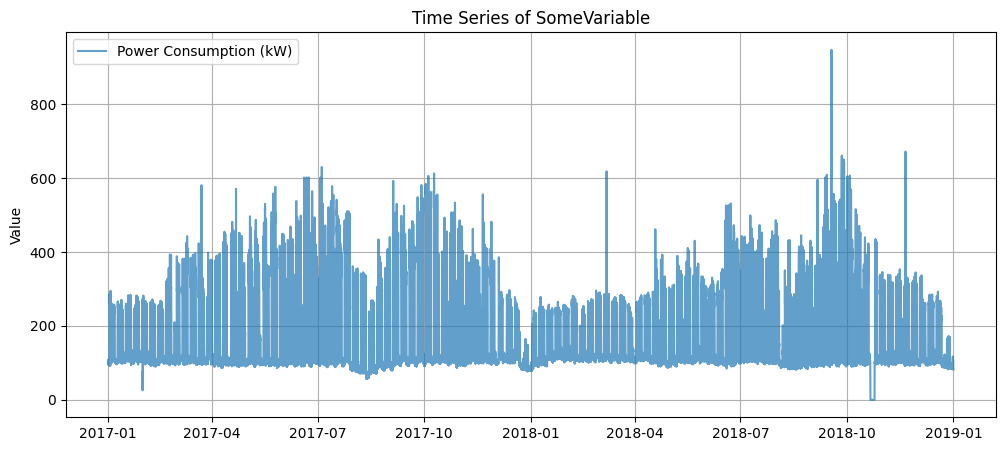

In [1451]:

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Power_kW"], label="Power Consumption (kW)", alpha=0.7)
plt.ylabel("Value")
plt.title("Time Series of SomeVariable")
plt.legend()
plt.grid()
plt.show()


Check if it is correctly ordered and if there are no duplicated data.



In [1452]:
print(df.head())
is_ordered = df.index.is_monotonic_increasing
print(f"Is the index ordered? {is_ordered}")


duplicates = df[df.index.duplicated(keep=False)]
print("Repeated Dates:",duplicates)
# We see that thare are no out of order data, but there are duplicated data,
# that correspond to the change of hours


                       Power_kW  Year  Month  Day  Hour
Date_start                                             
2017-01-01 00:00:00  100.810001  2017      1    1     0
2017-01-01 01:00:00   99.054135  2017      1    1     1
2017-01-01 02:00:00   98.539567  2017      1    1     2
2017-01-01 03:00:00  101.435784  2017      1    1     3
2017-01-01 04:00:00   98.481664  2017      1    1     4
Is the index ordered? True
Repeated Dates:                        Power_kW  Year  Month  Day  Hour
Date_start                                             
2017-10-29 01:00:00   91.317049  2017     10   29     1
2017-10-29 01:00:00   88.364240  2017     10   29     1
2018-10-28 01:00:00  103.303522  2018     10   28     1
2018-10-28 01:00:00  101.447365  2018     10   28     1


As we can see we were right. Let's fix it. As we can see it lost 2 entries (the duplicated ones).

In [1453]:


df = df.groupby("Date_start", as_index=True).agg({"Power_kW": "mean"}) # mean of their values

df.index = pd.to_datetime(df.index)

df["Year"] = df.index.year
df["Month"] = df.index.month
df["Day"] = df.index.day
df["Hour"] = df.index.hour



df.head()


Power_kW  Year  Month  Day  Hour
Date_start                                             
2017-01-01 00:00:00  100.810001  2017      1    1     0
2017-01-01 01:00:00   99.054135  2017      1    1     1
2017-01-01 02:00:00   98.539567  2017      1    1     2
2017-01-01 03:00:00  101.435784  2017      1    1     3
2017-01-01 04:00:00   98.481664  2017      1    1     4

Check for any missing data points

In [1454]:

full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="h")

missing_timestamps = full_range.difference(df.index)

print(missing_timestamps)

# Also because of the change of hour


DatetimeIndex(['2017-03-26 01:00:00', '2018-03-25 01:00:00'], dtype='datetime64[ns]', freq=None)


There are missing datapoint then let's interpolate and add them

In [1455]:
df = df.reindex(full_range)
df["Power_kW"] = df["Power_kW"].interpolate(method='linear')


full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="h")

missing_timestamps = full_range.difference(df.index)

print(missing_timestamps)


DatetimeIndex([], dtype='datetime64[ns]', freq='h')


## Meteo

In [1456]:

meteo_file_path = r"IST_meteo_data_2017_2018_2019.csv"
meteo_df = pd.read_csv(meteo_file_path)

meteo_df.rename(columns={'yyyy-mm-dd hh:mm:ss': 'Date_start'}, inplace=True)


meteo_df.index = pd.to_datetime(meteo_df.index)
meteo_df.set_index("Date_start", inplace=True)


meteo_df.head()

# We see that it is not a hourly data set




temp_C    HR  windSpeed_m/s  windGust_m/s  pres_mbar  \
Date_start                                                                 
2017-01-01 0:00:00    8.72  74.6          2.138         3.774       1029   
2017-01-01 0:05:00    8.68  74.6          1.929         3.019       1029   
2017-01-01 0:10:00    8.69  74.5          1.824         2.516       1029   
2017-01-01 0:15:00    8.62  75.1          2.264         3.271       1029   
2017-01-01 0:20:00    8.63  75.0          3.061         3.774       1029   

                    solarRad_W/m2  rain_mm/h  rain_day  
Date_start                                              
2017-01-01 0:00:00          1.163        0.0       0.0  
2017-01-01 0:05:00          1.496        0.0       0.0  
2017-01-01 0:10:00          1.025        0.0       0.0  
2017-01-01 0:15:00          1.690        0.0       0.0  
2017-01-01 0:20:00          1.108        0.0       0.0

So lets fix it

In [1457]:
# First lets order it

meteo_df.sort_index(inplace=True)
print("we fixed the order.  ", meteo_df.index.is_monotonic_increasing)
meteo_df.index = pd.to_datetime(meteo_df.index)

print(meteo_df.index.dtype)

# Fix the duplicated ones
meteo_df = meteo_df.groupby("Date_start").mean()

duplicates = meteo_df[meteo_df.index.duplicated(keep=False)]

print(meteo_df.index.duplicated().sum())

we fixed the order.   True
datetime64[ns]
0


Now turn the time step to hour making the adjustements on the features

In [1458]:
# Resampling to hourly data with appropriate aggregation
meteo_hourly = meteo_df.resample('H').agg({
    'temp_C': 'mean',
    'HR': 'mean',
    'windSpeed_m/s': 'mean',
    'windGust_m/s': 'max',
    'pres_mbar': 'mean',
    'solarRad_W/m2': 'mean',
    'rain_mm/h': 'mean',
    'rain_day': 'max'
})

meteo_hourly


C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\2118356764.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  meteo_hourly = meteo_df.resample('H').agg({


temp_C         HR  windSpeed_m/s  windGust_m/s  \
Date_start                                                               
2017-01-01 00:00:00   8.532500  74.966667       2.344500         3.774   
2017-01-01 01:00:00   7.930000  76.308333       2.692417         4.277   
2017-01-01 02:00:00   7.263417  80.275000       3.300250         4.780   
2017-01-01 03:00:00   6.831333  81.333333       3.534333         5.032   
2017-01-01 04:00:00   6.500250  81.241667       4.006000         6.793   
...                        ...        ...            ...           ...   
2019-04-11 11:00:00  15.615000  47.215000       0.000000         0.000   
2019-04-11 12:00:00  15.872500  46.630000       0.000000         0.000   
2019-04-11 13:00:00  16.315833  45.955833       0.000000         0.000   
2019-04-11 14:00:00  15.755455  45.820909       0.000000         0.000   
2019-04-11 15:00:00  15.290000  41.750000       0.000000         0.000   

                       pres_mbar  solarRad_W/m2  rain_mm/h  rain_day  
Date_start                                                            
2017-01-01 00:00:00  1029.000000       1.355083        0.0       0.0  
2017-01-01 01:00:00  1028.166667       1.477333        0.0       0.0  
2017-01-01 02:00:00  1028.000000       1.415083        0.0       0.0  
2017-01-01 03:00:00  1028.000000       1.542000        0.0       0.0  
2017-01-01 04:00:00  1028.000000       0.891000        0.0       0.0  
...                          ...            ...        ...       ...  
2019-04-11 11:00:00  1022.083333     869.200000        0.0       0.0  
2019-04-11 12:00:00  1022.000000     640.591667        0.0       0.0  
2019-04-11 13:00:00  1021.416667     855.808333        0.0       0.0  
2019-04-11 14:00:00  1021.090909     625.072727        0.0       0.0  
2019-04-11 15:00:00  1021.000000     519.750000        0.0       0.0  

[19936 rows x 8 columns]

Just use data until 2018-12-31 23:00:00

In [1459]:
cutoff_datetime = pd.Timestamp("2018-12-31 23:00:00")

meteo_hourly = meteo_hourly[meteo_hourly.index <= cutoff_datetime]


meteo_hourly.tail()

temp_C         HR  windSpeed_m/s  windGust_m/s  \
Date_start                                                               
2018-12-31 19:00:00  13.361667  54.013333            0.0           0.0   
2018-12-31 20:00:00  12.810000  55.441667            0.0           0.0   
2018-12-31 21:00:00  12.565000  55.291667            0.0           0.0   
2018-12-31 22:00:00  11.926667  56.530000            0.0           0.0   
2018-12-31 23:00:00  11.364167  57.886667            0.0           0.0   

                     pres_mbar  solarRad_W/m2  rain_mm/h  rain_day  
Date_start                                                          
2018-12-31 19:00:00     1031.0       1.112333        0.0       0.0  
2018-12-31 20:00:00     1031.0       1.322417        0.0       0.0  
2018-12-31 21:00:00     1031.0       1.195500        0.0       0.0  
2018-12-31 22:00:00     1031.0       1.117000        0.0       0.0  
2018-12-31 23:00:00     1031.0       1.324667        0.0       0.0

Checking if its missing any hour

In [1460]:

full_range = pd.date_range(start=meteo_hourly.index.min(), end=meteo_hourly.index.max(), freq="h")

missing_timestamps = full_range.difference(meteo_hourly.index)

print(missing_timestamps)


DatetimeIndex([], dtype='datetime64[ns]', freq='h')


Info about the data set now


In [1461]:
meteo_hourly.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Freq: h
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_C         15386 non-null  float64
 1   HR             15386 non-null  float64
 2   windSpeed_m/s  15386 non-null  float64
 3   windGust_m/s   15386 non-null  float64
 4   pres_mbar      15386 non-null  float64
 5   solarRad_W/m2  15386 non-null  float64
 6   rain_mm/h      15386 non-null  float64
 7   rain_day       15386 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


Checking for Nan or Nulls

In [1462]:
nan_counts = meteo_hourly.isna().sum()
if nan_counts.any():
    print("Missing values found in the dataset:")
    print(nan_counts[nan_counts > 0])

    nan_rows = meteo_hourly[meteo_hourly.isna().any(axis=1)]
    print("Rows with missing values:")
    print(nan_rows)
else:
    print("No missing values detected in the dataset.")


Missing values found in the dataset:
temp_C           2134
HR               2134
windSpeed_m/s    2134
windGust_m/s     2134
pres_mbar        2134
solarRad_W/m2    2134
rain_mm/h        2134
rain_day         2134
dtype: int64
Rows with missing values:
                     temp_C  HR  windSpeed_m/s  windGust_m/s  pres_mbar  \
Date_start                                                                
2017-01-30 22:00:00     NaN NaN            NaN           NaN        NaN   
2017-01-30 23:00:00     NaN NaN            NaN           NaN        NaN   
2017-01-31 00:00:00     NaN NaN            NaN           NaN        NaN   
2017-01-31 01:00:00     NaN NaN            NaN           NaN        NaN   
2017-01-31 02:00:00     NaN NaN            NaN           NaN        NaN   
...                     ...  ..            ...           ...        ...   
2018-12-12 01:00:00     NaN NaN            NaN           NaN        NaN   
2018-12-12 02:00:00     NaN NaN            NaN           NaN        NaN  

In [1463]:
meteo_hourly.iloc[715:730]

# There are a lot of NaN data that we will need to decide what to do with it
# But it would be counterproductive to see what and how to fill for all features
# if we are going to drop some of them


temp_C         HR  windSpeed_m/s  windGust_m/s  \
Date_start                                                               
2017-01-30 19:00:00  12.597500  78.608333       3.595583         5.535   
2017-01-30 20:00:00  12.095000  79.758333       2.909000         5.283   
2017-01-30 21:00:00  11.905556  80.255556       4.314222         7.040   
2017-01-30 22:00:00        NaN        NaN            NaN           NaN   
2017-01-30 23:00:00        NaN        NaN            NaN           NaN   
2017-01-31 00:00:00        NaN        NaN            NaN           NaN   
2017-01-31 01:00:00        NaN        NaN            NaN           NaN   
2017-01-31 02:00:00        NaN        NaN            NaN           NaN   
2017-01-31 03:00:00        NaN        NaN            NaN           NaN   
2017-01-31 04:00:00        NaN        NaN            NaN           NaN   
2017-01-31 05:00:00        NaN        NaN            NaN           NaN   
2017-01-31 06:00:00        NaN        NaN            NaN           NaN   
2017-01-31 07:00:00        NaN        NaN            NaN           NaN   
2017-01-31 08:00:00        NaN        NaN            NaN           NaN   
2017-01-31 09:00:00  10.878000  88.920000       3.417400         5.032   

                       pres_mbar  solarRad_W/m2  rain_mm/h  rain_day  
Date_start                                                            
2017-01-30 19:00:00  1018.666667        1.52775       0.00       0.0  
2017-01-30 20:00:00  1018.000000        1.43325       0.00       0.0  
2017-01-30 21:00:00  1017.777778        2.03400       0.00       0.0  
2017-01-30 22:00:00          NaN            NaN        NaN       NaN  
2017-01-30 23:00:00          NaN            NaN        NaN       NaN  
2017-01-31 00:00:00          NaN            NaN        NaN       NaN  
2017-01-31 01:00:00          NaN            NaN        NaN       NaN  
2017-01-31 02:00:00          NaN            NaN        NaN       NaN  
2017-01-31 03:00:00          NaN            NaN        NaN       NaN  
2017-01-31 04:00:00          NaN            NaN        NaN       NaN  
2017-01-31 05:00:00          NaN            NaN        NaN       NaN  
2017-01-31 06:00:00          NaN            NaN        NaN       NaN  
2017-01-31 07:00:00          NaN            NaN        NaN       NaN  
2017-01-31 08:00:00          NaN            NaN        NaN       NaN  
2017-01-31 09:00:00  1014.000000       26.29400       0.56       0.9

## Merge power and meteo

In [1464]:
merged_df = df.merge(meteo_hourly, left_index=True, right_index=True, how="inner")
merged_df.head()


Power_kW    Year  Month  Day  Hour    temp_C  \
2017-01-01 00:00:00  100.810001  2017.0    1.0  1.0   0.0  8.532500   
2017-01-01 01:00:00   99.054135  2017.0    1.0  1.0   1.0  7.930000   
2017-01-01 02:00:00   98.539567  2017.0    1.0  1.0   2.0  7.263417   
2017-01-01 03:00:00  101.435784  2017.0    1.0  1.0   3.0  6.831333   
2017-01-01 04:00:00   98.481664  2017.0    1.0  1.0   4.0  6.500250   

                            HR  windSpeed_m/s  windGust_m/s    pres_mbar  \
2017-01-01 00:00:00  74.966667       2.344500         3.774  1029.000000   
2017-01-01 01:00:00  76.308333       2.692417         4.277  1028.166667   
2017-01-01 02:00:00  80.275000       3.300250         4.780  1028.000000   
2017-01-01 03:00:00  81.333333       3.534333         5.032  1028.000000   
2017-01-01 04:00:00  81.241667       4.006000         6.793  1028.000000   

                     solarRad_W/m2  rain_mm/h  rain_day  
2017-01-01 00:00:00       1.355083        0.0       0.0  
2017-01-01 01:00:00       1.477333        0.0       0.0  
2017-01-01 02:00:00       1.415083        0.0       0.0  
2017-01-01 03:00:00       1.542000        0.0       0.0  
2017-01-01 04:00:00       0.891000        0.0       0.0

# Exploratory Data Analysis

In [1465]:
merged_df

Power_kW    Year  Month   Day  Hour     temp_C  \
2017-01-01 00:00:00  100.810001  2017.0    1.0   1.0   0.0   8.532500   
2017-01-01 01:00:00   99.054135  2017.0    1.0   1.0   1.0   7.930000   
2017-01-01 02:00:00   98.539567  2017.0    1.0   1.0   2.0   7.263417   
2017-01-01 03:00:00  101.435784  2017.0    1.0   1.0   3.0   6.831333   
2017-01-01 04:00:00   98.481664  2017.0    1.0   1.0   4.0   6.500250   
...                         ...     ...    ...   ...   ...        ...   
2018-12-31 19:00:00   97.217861  2018.0   12.0  31.0  19.0  13.361667   
2018-12-31 20:00:00   95.928710  2018.0   12.0  31.0  20.0  12.810000   
2018-12-31 21:00:00   85.652000  2018.0   12.0  31.0  21.0  12.565000   
2018-12-31 22:00:00   90.360675  2018.0   12.0  31.0  22.0  11.926667   
2018-12-31 23:00:00   81.954980  2018.0   12.0  31.0  23.0  11.364167   

                            HR  windSpeed_m/s  windGust_m/s    pres_mbar  \
2017-01-01 00:00:00  74.966667       2.344500         3.774  1029.000000   
2017-01-01 01:00:00  76.308333       2.692417         4.277  1028.166667   
2017-01-01 02:00:00  80.275000       3.300250         4.780  1028.000000   
2017-01-01 03:00:00  81.333333       3.534333         5.032  1028.000000   
2017-01-01 04:00:00  81.241667       4.006000         6.793  1028.000000   
...                        ...            ...           ...          ...   
2018-12-31 19:00:00  54.013333       0.000000         0.000  1031.000000   
2018-12-31 20:00:00  55.441667       0.000000         0.000  1031.000000   
2018-12-31 21:00:00  55.291667       0.000000         0.000  1031.000000   
2018-12-31 22:00:00  56.530000       0.000000         0.000  1031.000000   
2018-12-31 23:00:00  57.886667       0.000000         0.000  1031.000000   

                     solarRad_W/m2  rain_mm/h  rain_day  
2017-01-01 00:00:00       1.355083        0.0       0.0  
2017-01-01 01:00:00       1.477333        0.0       0.0  
2017-01-01 02:00:00       1.415083        0.0       0.0  
2017-01-01 03:00:00       1.542000        0.0       0.0  
2017-01-01 04:00:00       0.891000        0.0       0.0  
...                            ...        ...       ...  
2018-12-31 19:00:00       1.112333        0.0       0.0  
2018-12-31 20:00:00       1.322417        0.0       0.0  
2018-12-31 21:00:00       1.195500        0.0       0.0  
2018-12-31 22:00:00       1.117000        0.0       0.0  
2018-12-31 23:00:00       1.324667        0.0       0.0  

[17520 rows x 13 columns]

## Quick Statistic

We can see that the meteo information have some NaN information.

Also we can have a little perception of the quartiles, the max and min values, and also the mean and std.

In [1466]:
merged_df.describe()


Power_kW          Year         Month           Day          Hour  \
count  17520.000000  17518.000000  17518.000000  17518.000000  17518.000000   
mean     175.732057   2017.500000      6.526430     15.719431     11.501199   
std      113.663982      0.500014      3.447941      8.796378      6.921870   
min        0.000000   2017.000000      1.000000      1.000000      0.000000   
25%      100.669286   2017.000000      4.000000      8.000000      6.000000   
50%      111.587622   2017.500000      7.000000     16.000000     12.000000   
75%      242.475295   2018.000000     10.000000     23.000000     17.750000   
max      947.059190   2018.000000     12.000000     31.000000     23.000000   

             temp_C            HR  windSpeed_m/s  windGust_m/s     pres_mbar  \
count  15386.000000  15386.000000   15386.000000  15386.000000  15386.000000   
mean      16.273382     60.009149       1.771796      3.103596   1018.991534   
std        5.219923     17.334437       2.573319      4.323742      6.604640   
min        2.948417      9.680833       0.000000      0.000000    979.916667   
25%       12.369183     48.090833       0.000000      0.000000   1015.833333   
50%       15.880417     62.274583       0.000000      0.000000   1019.000000   
75%       19.452917     73.181250       3.520375      6.289000   1022.583333   
max       41.048333     98.625000      14.568333     23.400000   1039.583333   

       solarRad_W/m2     rain_mm/h      rain_day  
count   15386.000000  15386.000000  15386.000000  
mean      207.454456      0.050919      0.624171  
std       285.129137      0.377248      2.602446  
min         0.000000      0.000000      0.000000  
25%         1.697521      0.000000      0.000000  
50%        17.172417      0.000000      0.000000  
75%       375.677083      0.000000      0.000000  
max      1053.825000     16.408333     34.500000

## Data Visualization


**Box plots**

First is important to understand how to read a boxplot:

- **Median (Q2)**: The central value (orange line inside the box).
- **Interquartile Range (IQR)**: The middle 50% of data, between **Q1 (25th percentile)** and **Q3 (75th percentile)**.
- **Whiskers**: Extend to the minimum and maximum values within **1.5 x IQR** -> Whisker Max: Q3 + 1.5* IQR // Whisker Min: Q1-1.5*IQR
- **Outliers**: Data points **beyond the whiskers**, shown as circles.

Now if we look to the box plots and to the quick statistics values we can see that they are according to each other.

Also, even though supposedly all of the points above the upper whisker and under the bottom whisker are considered outliers in reality they can not be. Let's plot the features to see this better.


1. Power
- Wide box: High variability in power consumption.
- Many outliers above whiskers: Indicates spikes in power usage.
- Slightly skewed upwards: Power usage may have extreme high values.

2. Temperature
- Mostly symmetrical: Temperature values are evenly distributed.
- Some outliers above Q3: Few very high-temperature values.
- No extreme skew: Normal seasonal temperature variations.
3. Humidity (HR)
- More symmetric: Indicates a stable range of humidity.
- Some lower outliers: Possibly extremely dry conditions.
- Whiskers show good spread: Variations are natural but mostly within expected range.
4. Wind Speed
- Significant outliers: Some very strong wind events.
- Skewed right: Most values are low, with some extreme wind speeds.
- Box is small: Regular wind speeds don't vary much.
5. Wind Gust
- Very large number of outliers: Indicates occasional strong gusts.
- Right-skewed: Most gusts are low, but rare storms cause high values.
- Small box: Typical wind gusts remain low but outliers are frequent.
6. Pressure
- Relatively stable (small box): Atmospheric pressure doesn’t change drastically.
- Many outliers below Q1: Possibly low-pressure weather systems (e.g., storms).
- Slight negative skew: More extreme low-pressure events than high-pressure ones.
7. Solar Radiation
- Strong right-skew: Most values are near zero (nighttime), with extreme highs (daytime).
- Large range: Solar radiation is highly variable between day and night.
- Many outliers: Possibly peak sunshine hours causing extreme values.
8. Rain Rate
- Highly skewed right: Most hours have no rain, but some experience intense downpours.
- Many outliers: Rainfall is sporadic, with rare heavy rain events.
- Small box (low IQR): Most hours have very little rain.
9. Daily Rainfall (rain_day)
- Extreme outliers: Some days experience very heavy rainfall.
- Mostly near zero: Many dry days.
- Right skew: Indicates a few days have significantly higher rain than usual.


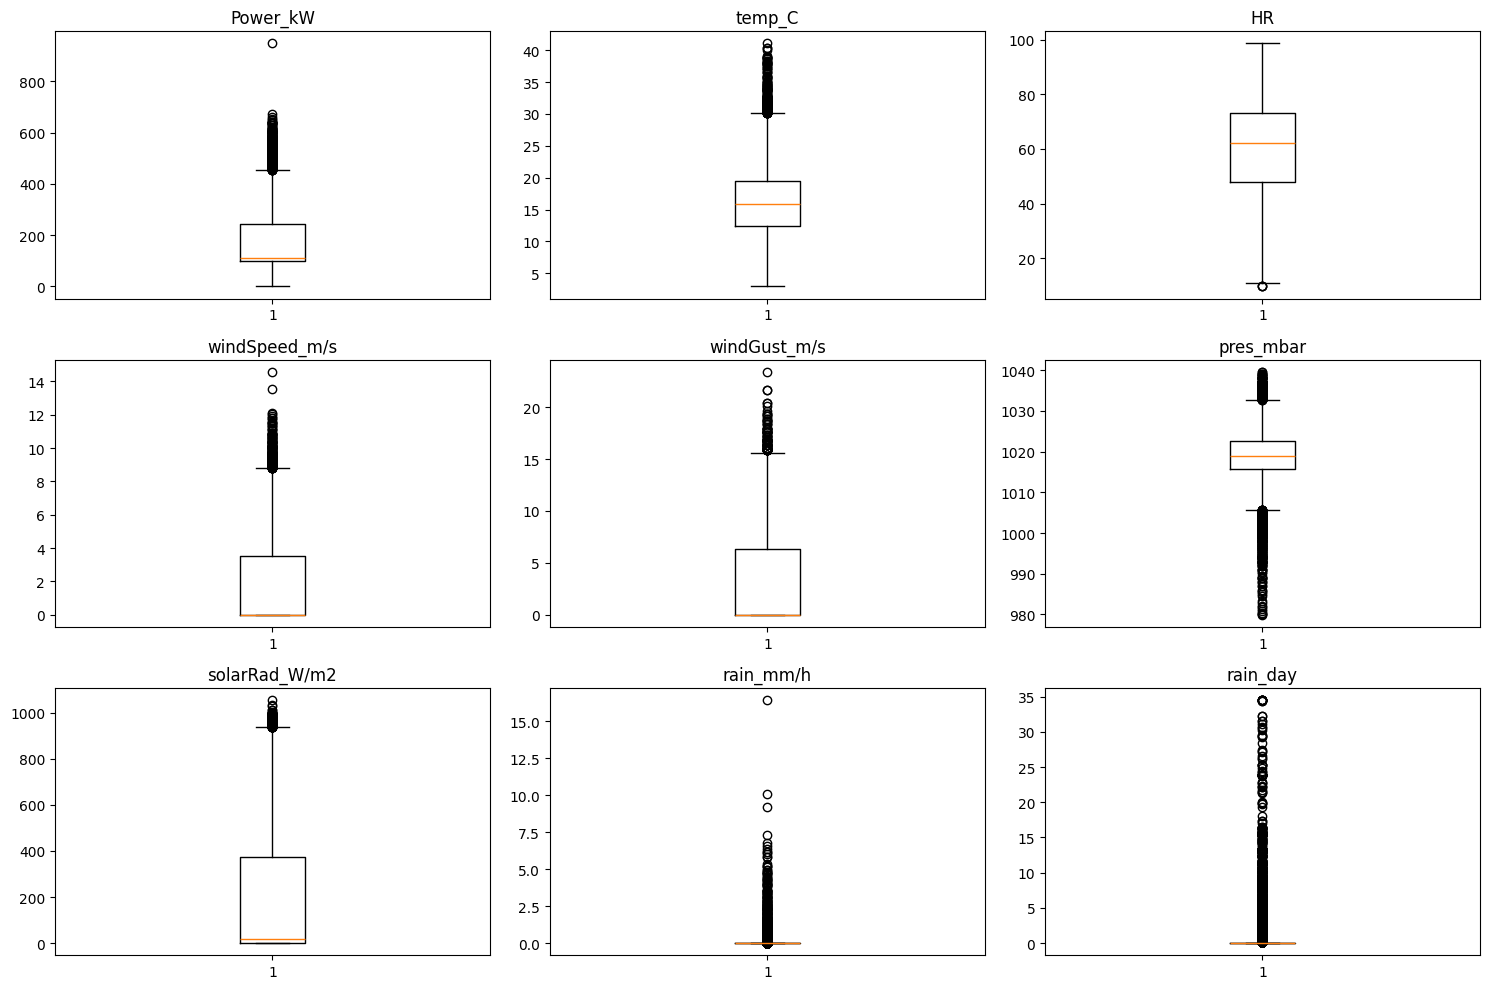

In [1467]:

plt.figure(figsize=(15, 10))
for i, feature in enumerate(merged_df.drop(columns = ['Year','Hour','Month','Day']),1):
    plt.subplot(3, 3, i)
    plt.boxplot(merged_df[feature].dropna())  # Drop NaN values for clean boxplots
    plt.title(feature)

plt.tight_layout()
plt.show()

**Plots**

As you can see for example in temperature graph, there are days that reached ~40ºC. Looking for the boxplots and quick statistics they are considered outliers. But in fact they are not, these days actually happened.

Meaning that even though some boxplots consider some observations outliers they may not be, and vice-versa.

Other thing that we can see that is weird is the fact that wind speed and wind gust as a lot of 0 values, which is highly unlikely to happen to have days without any wind, mainly in Lisbon that is a coastal city and also in south tower that is a extremely high building.

We can also see some trends for example temperature, HR and solar radiation.


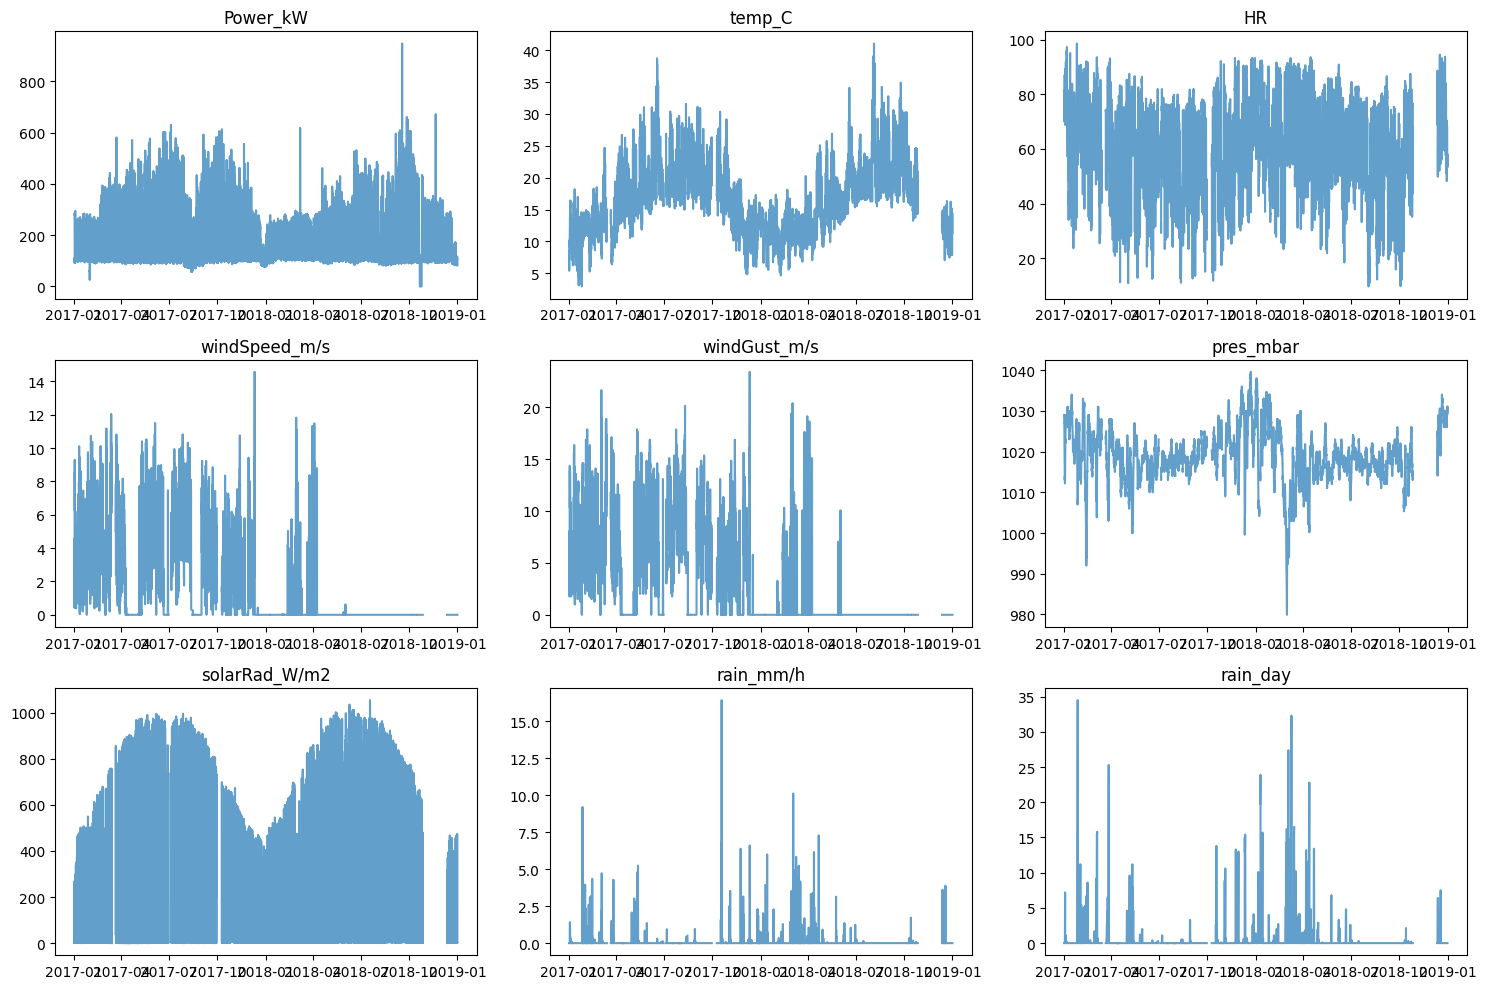

In [1468]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(merged_df.drop(columns = ['Year','Hour','Month','Day']), 1):
    plt.subplot(3, 3, i)
    plt.plot(merged_df.index, merged_df[feature], alpha=0.7)
    plt.title(feature)

plt.tight_layout()
plt.show()



## Z-Score and IQR



Normal Box Plot:


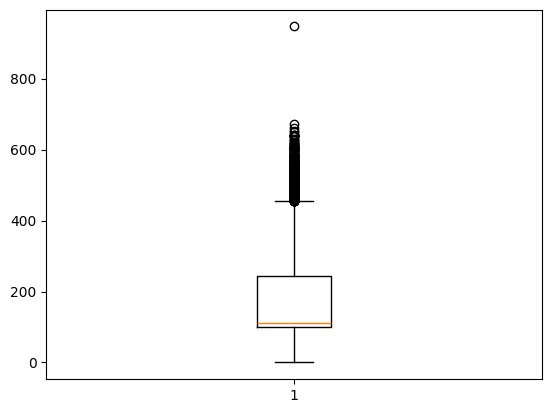

Z-score Box Plot:


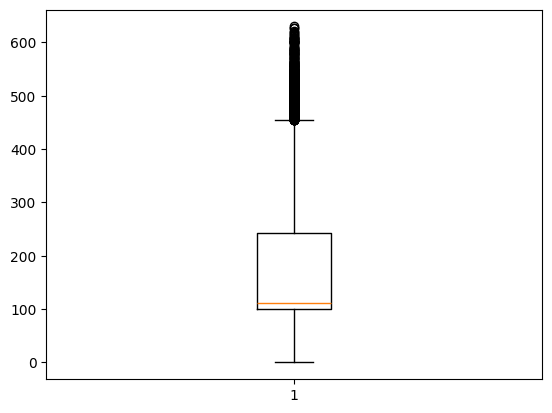

IQR Box Plot:


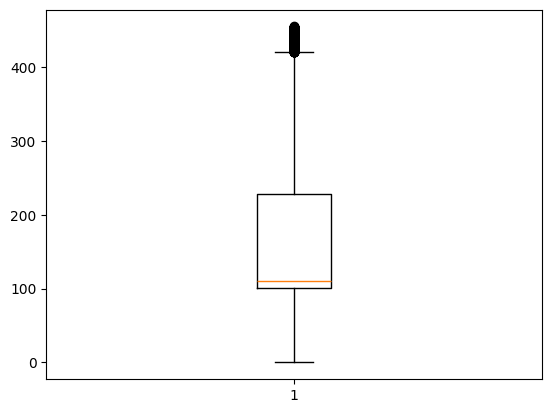

Normal Plot:


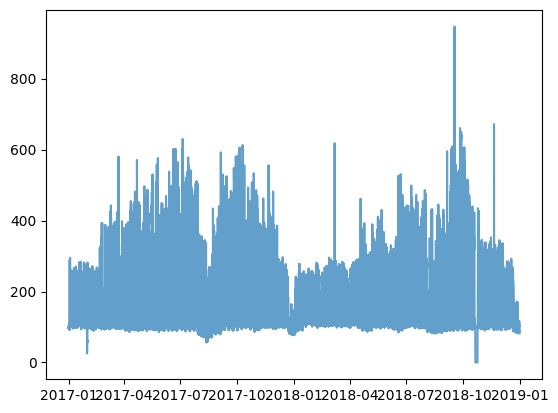

Z-score Plot:


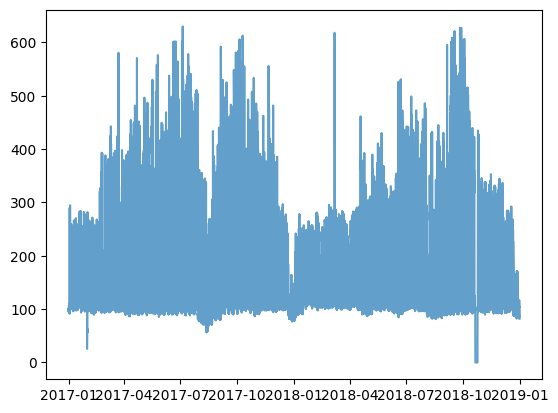

IQR Plot:


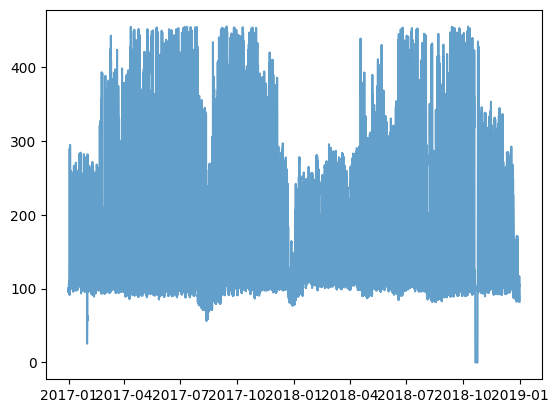

In [1469]:
from scipy import stats

def remove_outliers_zscore(df, columns, threshold=3):
    df_clean = df.copy()
    for col in columns:
        z_scores = np.abs(stats.zscore(df_clean[col], nan_policy='omit'))
        df_clean = df_clean[z_scores < threshold]
    return df_clean

def remove_outliers_iqr(df, columns, factor=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[(df_clean[col] >= (Q1 - factor * IQR)) &
                            (df_clean[col] <= (Q3 + factor * IQR))]
    return df_clean

#df_zscore = remove_outliers_zscore(merged_df, ['Power_kW'], 3)
df_zscore = remove_outliers_zscore(merged_df, ['Power_kW'], 4)


df_iqr = remove_outliers_iqr(merged_df, ['Power_kW'])

print("Normal Box Plot:")
plt.boxplot(merged_df['Power_kW'])
plt.show()

print("Z-score Box Plot:")

plt.boxplot(df_zscore['Power_kW'])
plt.show()

print("IQR Box Plot:")

plt.boxplot(df_iqr['Power_kW'])
plt.show()

print("Normal Plot:")

plt.plot(merged_df.index, merged_df['Power_kW'], alpha=0.7)
plt.show()

print("Z-score Plot:")

plt.plot(df_zscore.index, df_zscore['Power_kW'], alpha=0.7)
plt.show()

print("IQR Plot:")

plt.plot(df_iqr.index, df_iqr['Power_kW'], alpha=0.7)
plt.show()




We can see that both Z-score and IQR methods can't delete the lower outliers. Both methods delete the higher outliers, with IQR deleting even more that the Z-score.

So we can make a mix of methods. For example, I will decide to use Z-score, because I consider that it erased well the upper outliers and for the lowers I will just say that everything lower then the lowest of the month of august will be removed (because august is holidays and it's when tecnico closes).

Merged_df =  (17520, 13)
df_zscore =  (17507, 13)
Merged_df after Z-Score and Power > 60kW :  (17399, 13)


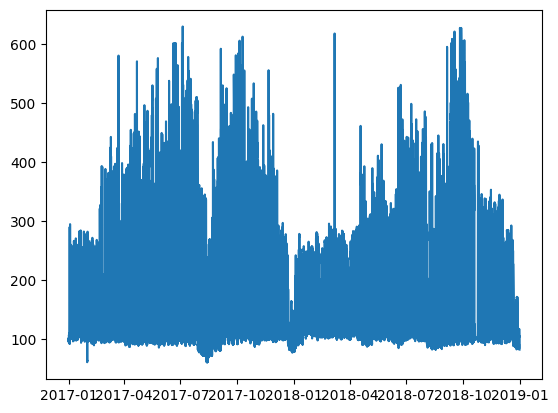

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17399 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power_kW       17399 non-null  float64
 1   Year           17397 non-null  float64
 2   Month          17397 non-null  float64
 3   Day            17397 non-null  float64
 4   Hour           17397 non-null  float64
 5   temp_C         15284 non-null  float64
 6   HR             15284 non-null  float64
 7   windSpeed_m/s  15284 non-null  float64
 8   windGust_m/s   15284 non-null  float64
 9   pres_mbar      15284 non-null  float64
 10  solarRad_W/m2  15284 non-null  float64
 11  rain_mm/h      15284 non-null  float64
 12  rain_day       15284 non-null  float64
dtypes: float64(13)
memory usage: 1.9 MB


In [1470]:
print("Merged_df = ", merged_df.shape)
print("df_zscore = ", df_zscore.shape)


merged_df = df_zscore
merged_df = merged_df[merged_df['Power_kW'] > 60 ]

print("Merged_df after Z-Score and Power > 60kW : ", merged_df.shape)

plt.plot(merged_df.index,merged_df[['Power_kW']])
plt.show()

merged_df.info()


In [1471]:
merged_df = merged_df.reset_index().rename(columns={"index": "Date_start"})


merged_df.to_csv('Power_Meteo_Merged.csv', encoding='utf-8', index=False)


# Feature Selection

In [1596]:

merged_df = pd.read_csv(r'Power_Meteo_Merged.csv')

merged_df = merged_df.set_index('Date_start') # make 'datetime' into index

merged_df.index = pd.to_datetime(merged_df.index)

merged_df.head()


Power_kW    Year  Month  Day  Hour    temp_C  \
Date_start                                                            
2017-01-01 00:00:00  100.810001  2017.0    1.0  1.0   0.0  8.532500   
2017-01-01 01:00:00   99.054135  2017.0    1.0  1.0   1.0  7.930000   
2017-01-01 02:00:00   98.539567  2017.0    1.0  1.0   2.0  7.263417   
2017-01-01 03:00:00  101.435784  2017.0    1.0  1.0   3.0  6.831333   
2017-01-01 04:00:00   98.481664  2017.0    1.0  1.0   4.0  6.500250   

                            HR  windSpeed_m/s  windGust_m/s    pres_mbar  \
Date_start                                                                 
2017-01-01 00:00:00  74.966667       2.344500         3.774  1029.000000   
2017-01-01 01:00:00  76.308333       2.692417         4.277  1028.166667   
2017-01-01 02:00:00  80.275000       3.300250         4.780  1028.000000   
2017-01-01 03:00:00  81.333333       3.534333         5.032  1028.000000   
2017-01-01 04:00:00  81.241667       4.006000         6.793  1028.000000   

                     solarRad_W/m2  rain_mm/h  rain_day  
Date_start                                               
2017-01-01 00:00:00       1.355083        0.0       0.0  
2017-01-01 01:00:00       1.477333        0.0       0.0  
2017-01-01 02:00:00       1.415083        0.0       0.0  
2017-01-01 03:00:00       1.542000        0.0       0.0  
2017-01-01 04:00:00       0.891000        0.0       0.0

## Preliminary Feature Selection

### Plot of Meteo

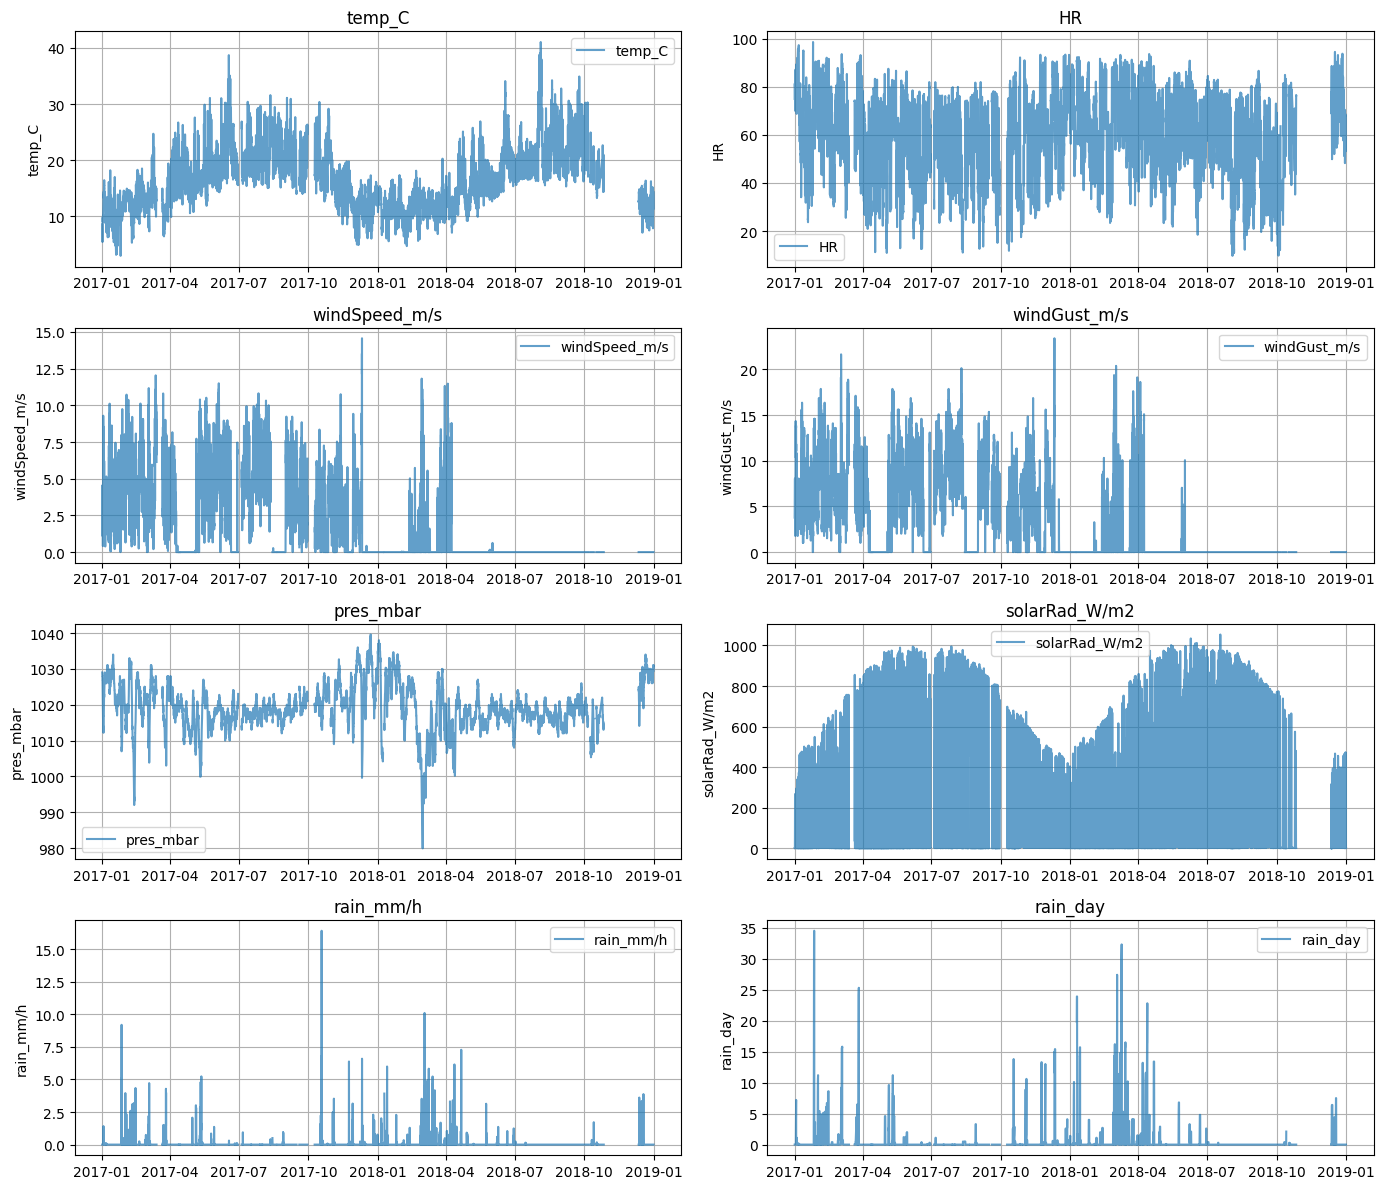

In [1597]:
features = ["temp_C", "HR", "windSpeed_m/s", "windGust_m/s", "pres_mbar",
            "solarRad_W/m2", "rain_mm/h", "rain_day"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].plot(merged_df.index, merged_df[feature], label=feature, alpha=0.7)
    axes[i].set_title(feature)
    axes[i].set_ylabel(feature)
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


### Intuiton + Correlation Matrix

So, windSpeed_m/s and windGust_m/s (0.97) are redundant. We also have a high correlation between rain_mm/h and rain_day.

Let's think if these features make sense. So the wind, for a big tower like south tower can be important, because wind affects ventilation and air pressure inside the building and if the tower has natural ventilation, wind speed influences airflow.

For the rain, the solar panels were putted after 2019 so rain will probably not be important, because the only thing that it would do would be someting like covering the photovoltaic cells and create a problem. Since it is not the case we can ignore this feature.

If we notice also the HR and the solarRad and HR and the temperature are inverse correlated, because more solar radiation (sunlight) dries out the air, reducing humidity and warmer temperatures lead to lower humidity.

The pressure also doesn't matter that much unless south tower has pressure-controlled rooms but looking to the graph of pressure it doesn't oscillates a lot so it would be not "pressure" dependent.

Now looking to the graphs lets see how to deal with the missing data problem.

For the wind speed we can see that a lot of results are 0, which is weird since having no wind is highly improbable (maybe some sensor malfunction or calibration issues). The graph also seems super random, meaning that probably we can not do nothing with that, we can not complete the places with no data. So, the quantity of zeros due to maybe malfunction of something plus the missing data makes and plus the fact that the wind is super random we may need to drop this feature too, even though it could be important. But since the other features are way stronger predictors of energy consumption we can drop it and rest assure that it's not this feature drop that will make our model terrible.

So we end up with temperature, solar radiation and HR. Since they are "predictable" and "follows" a pattern we can use interpolation or just past some previous information.


We will also use filter methods and Wrapper Methods to help us decide.

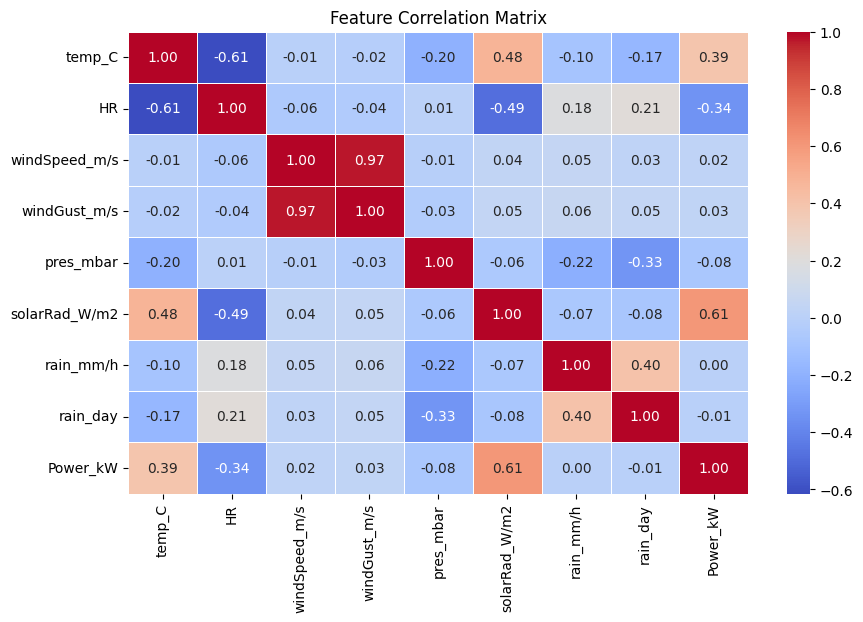

In [1598]:
import seaborn as sns


correlation_matrix = merged_df[features + ['Power_kW']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

### Filter Methods

#### K-Best

##### F-Test

This method also agrees with what we said before, that the most important of them are solarRad, temp, HR.

[2.81109322e+03 2.02201588e+03 8.06617327e+00 1.30560195e+01
 9.01744135e+01 8.92462044e+03 3.82337215e-02 9.40917284e-01]
[[ 8.5325     74.96666667  1.35508333]
 [ 7.93       76.30833333  1.47733333]
 [ 7.26341667 80.275       1.41508333]
 ...
 [12.565      55.29166667  1.1955    ]
 [11.92666667 56.53        1.117     ]
 [11.36416667 57.88666667  1.32466667]]


<BarContainer object of 8 artists>

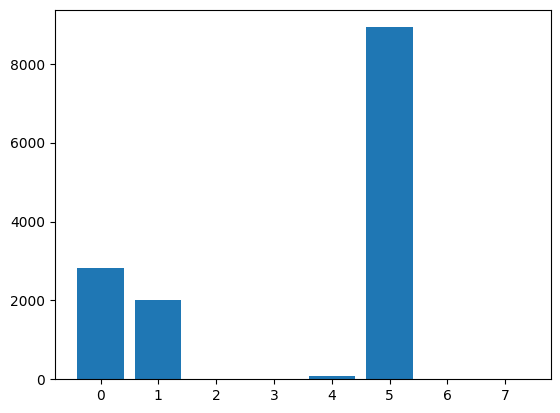

In [1599]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression,f_regression

feature=SelectKBest(k=3,score_func=f_regression)

merged_copy = merged_df.dropna()



fit=feature.fit(merged_copy[features],merged_copy["Power_kW"]) #calculates the scores using the score_function f_regression of the features
print(fit.scores_)
features_results=fit.transform(merged_copy[features])
print(features_results)


plt.bar([i for i in range(len(fit.scores_))], fit.scores_) # solarRad, temp, HR

##### Mutual-Information

This method also agrees with what we said before, that the most important of them are solarRad, temp, HR. It also atributes some importation to the pressure.

[0.21678192 0.10902286 0.03407217 0.03407379 0.0948239  0.32022485
 0.00955843 0.05817142]


<BarContainer object of 8 artists>

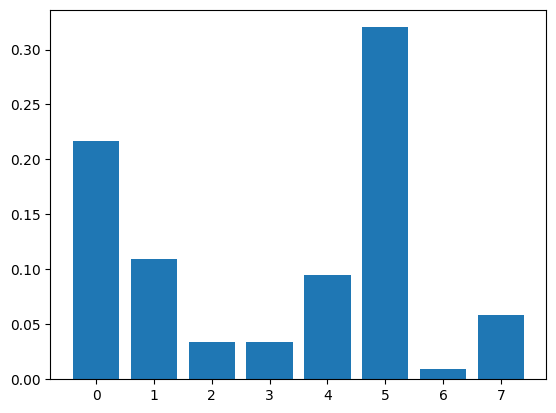

In [1600]:
feature=SelectKBest(k=3,score_func=mutual_info_regression)

fit=feature.fit(merged_copy[features],merged_copy['Power_kW'])
print(fit.scores_) #solarRad, temp, HR
plt.bar([i for i in range(len(fit.scores_))], fit.scores_) # solarRad, temp, HR


### Wrapper Methods

#### Recursive Feature Elimination (RFE)

This method actually says that HR is the most important feature, then pressure and then solarRad, excluding temperature from this top 3. We will follow the other methods because they also converge with our intuiton.

<BarContainer object of 8 artists>

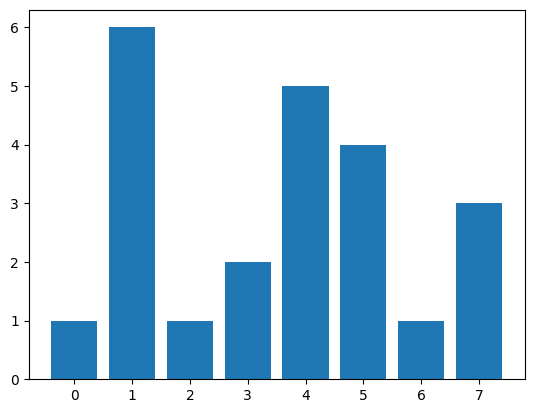

In [1601]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()

selector = RFE(estimator, n_features_to_select=3)

selector.fit(merged_copy[features], merged_copy["Power_kW"])

plt.bar([i for i in range(len(selector.ranking_))], selector.ranking_) #HR ,Pressure ,solarRad



### Drop Features and Complete missing Data

Drop the other features except temperature, HR and solarRad.

Removed Month, day and hour to don't deal with them. I can add them anytime I need it.

In [1602]:
merged_df = merged_df.drop(columns = ['rain_mm/h', 'rain_day', 'pres_mbar', 'windGust_m/s', 'windSpeed_m/s', 'Day', 'Hour', 'Month', 'Year'])
merged_df.head()

Power_kW    temp_C         HR  solarRad_W/m2
Date_start                                                         
2017-01-01 00:00:00  100.810001  8.532500  74.966667       1.355083
2017-01-01 01:00:00   99.054135  7.930000  76.308333       1.477333
2017-01-01 02:00:00   98.539567  7.263417  80.275000       1.415083
2017-01-01 03:00:00  101.435784  6.831333  81.333333       1.542000
2017-01-01 04:00:00   98.481664  6.500250  81.241667       0.891000

Find data missing.

In [1603]:

# ensure All Hourly Timestamps Exist (some may be dropped when I removed the outliers)
full_date_range = pd.date_range(start=merged_df.index.min(), end=merged_df.index.max(), freq='H')

merged_df = merged_df.reindex(full_date_range)
merged_df.index.name = 'Date_start'  # restore index name

print(merged_df.isna().sum())  # Check if NaNs still exist


nan_rows = merged_df.isna().any(axis=1)

intervals = []
start = None

for i, is_nan in enumerate(nan_rows):
    if is_nan:
        if start is None:
            start = i
    else:
        if start is not None:
            intervals.append((start, i - 1))
            start = None

if start is not None:
    intervals.append((start, len(merged_df) - 1))

for inter in intervals:
    print(f"{merged_df.index[inter[0]]} -> {merged_df.index[inter[1]]}")




Power_kW          121
temp_C           2236
HR               2236
solarRad_W/m2    2236
dtype: int64
2017-01-30 20:00:00 -> 2017-01-30 20:00:00
2017-01-30 22:00:00 -> 2017-01-31 08:00:00
2017-03-13 23:00:00 -> 2017-03-21 06:00:00
2017-04-12 02:00:00 -> 2017-04-12 13:00:00
2017-04-13 17:00:00 -> 2017-04-15 01:00:00
2017-05-11 01:00:00 -> 2017-05-11 06:00:00
2017-06-30 00:00:00 -> 2017-07-04 13:00:00
2017-07-17 01:00:00 -> 2017-07-17 13:00:00
2017-07-28 09:00:00 -> 2017-07-29 00:00:00
2017-07-31 17:00:00 -> 2017-07-31 21:00:00
2017-08-12 03:00:00 -> 2017-08-14 08:00:00
2017-08-19 07:00:00 -> 2017-08-21 07:00:00
2017-09-15 08:00:00 -> 2017-09-18 22:00:00
2017-09-29 18:00:00 -> 2017-10-09 05:00:00
2017-10-28 16:00:00 -> 2017-10-30 01:00:00
2017-10-30 03:00:00 -> 2017-10-30 11:00:00
2018-01-07 20:00:00 -> 2018-01-09 11:00:00
2018-09-17 17:00:00 -> 2018-09-17 17:00:00
2018-09-26 12:00:00 -> 2018-09-26 16:00:00
2018-09-27 11:00:00 -> 2018-09-27 12:00:00
2018-09-28 12:00:00 -> 2018-09-28 12:00

C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\2861651432.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(start=merged_df.index.min(), end=merged_df.index.max(), freq='H')


In [1604]:
merged_df

Power_kW     temp_C         HR  solarRad_W/m2
Date_start                                                          
2017-01-01 00:00:00  100.810001   8.532500  74.966667       1.355083
2017-01-01 01:00:00   99.054135   7.930000  76.308333       1.477333
2017-01-01 02:00:00   98.539567   7.263417  80.275000       1.415083
2017-01-01 03:00:00  101.435784   6.831333  81.333333       1.542000
2017-01-01 04:00:00   98.481664   6.500250  81.241667       0.891000
...                         ...        ...        ...            ...
2018-12-31 19:00:00   97.217861  13.361667  54.013333       1.112333
2018-12-31 20:00:00   95.928710  12.810000  55.441667       1.322417
2018-12-31 21:00:00   85.652000  12.565000  55.291667       1.195500
2018-12-31 22:00:00   90.360675  11.926667  56.530000       1.117000
2018-12-31 23:00:00   81.954980  11.364167  57.886667       1.324667

[17520 rows x 4 columns]

Complete the missing data.

In [1605]:
#-------------------------------------
# Function to handle missing values
#-------------------------------------


def fill_missing_values(df):
    for col in df.columns:
        missing_mask = df[col].isna()

        gap_groups = (missing_mask != missing_mask.shift()).cumsum() * missing_mask

        gap_sizes = gap_groups.value_counts()

        # Forward-fill gaps between 5 and 24 hours
        valid_gaps = gap_sizes[(gap_sizes > 5) & (gap_sizes < 24)].index
        for gap in valid_gaps:
            df.loc[gap_groups == gap, col] = df[col].ffill()

        # Handle gaps > 24 hours using previous or next year's data
        large_gaps = gap_sizes[gap_sizes >= 24].index
        for gap in large_gaps:
            gap_indices = df[gap_groups == gap].index
            for idx in gap_indices:
                year = idx.year
                if year == 2018:
                    prev_year_idx = idx.replace(year=2017) if idx.replace(year=2017) in df.index else None
                    if prev_year_idx and not pd.isna(df.at[prev_year_idx, col]):
                        df.at[idx, col] = df.at[prev_year_idx, col]
                elif year == 2017:
                    next_year_idx = idx.replace(year=2018) if idx.replace(year=2018) in df.index else None
                    if next_year_idx and not pd.isna(df.at[next_year_idx, col]):
                        df.at[idx, col] = df.at[next_year_idx, col]

    # linear interpolation for small gaps (<5 hours)
    df.interpolate(method='linear', limit=4, limit_direction='both', inplace=True)

    return df


In [1606]:
# If gap < 5h I do interpolation.
# if the gap is < 1 day I use the data from the previous day
# If the gap is > 1 day I want to use the data from the next/previous year.

merged_df = fill_missing_values(merged_df)

print("Remaining missing values:\n", merged_df.isna().sum())


Remaining missing values:
 Power_kW           0
temp_C           170
HR               170
solarRad_W/m2    170
dtype: int64


In [1607]:
merged_df

Power_kW     temp_C         HR  solarRad_W/m2
Date_start                                                         
2017-01-01 00:00:00  80.047693  11.686667  67.979167       1.100750
2017-01-01 01:00:00  81.376392  11.239167  70.430000       0.941667
2017-01-01 02:00:00  79.450315  10.735833  75.283333       0.734083
2017-01-01 03:00:00  78.523656  10.744167  76.466667       1.237500
2017-01-01 04:00:00  78.947765  11.012500  76.475000       1.288167
...                        ...        ...        ...            ...
2018-12-31 19:00:00  97.217861  13.361667  54.013333       1.112333
2018-12-31 20:00:00  95.928710  12.810000  55.441667       1.322417
2018-12-31 21:00:00  85.652000  12.565000  55.291667       1.195500
2018-12-31 22:00:00  90.360675  11.926667  56.530000       1.117000
2018-12-31 23:00:00  81.954980  11.364167  57.886667       1.324667

[17520 rows x 4 columns]

Check if is still missing anything

In [1608]:


# ensure All Hourly Timestamps Exist (some may be dropped when I removed the outliers)
full_date_range = pd.date_range(start=merged_df.index.min(), end=merged_df.index.max(), freq='H')

merged_df = merged_df.reindex(full_date_range)
merged_df.index.name = 'Date_start'  # restore index name

print(merged_df.isna().sum())  # Check if NaNs still exist


nan_rows = merged_df.isna().any(axis=1)

intervals = []
start = None

for i, is_nan in enumerate(nan_rows):
    if is_nan:
        if start is None:
            start = i
    else:
        if start is not None:
            intervals.append((start, i - 1))
            start = None

if start is not None:
    intervals.append((start, len(merged_df) - 1))

for inter in intervals:
    print(f"{merged_df.index[inter[0]]} -> {merged_df.index[inter[1]]}")




merged_df = merged_df.dropna()

merged_df.info()


Power_kW           0
temp_C           170
HR               170
solarRad_W/m2    170
dtype: int64
2017-10-06 12:00:00 -> 2017-10-08 22:00:00
2017-10-28 20:00:00 -> 2017-10-29 21:00:00
2018-10-06 12:00:00 -> 2018-10-08 22:00:00
2018-10-28 20:00:00 -> 2018-10-29 21:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17350 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power_kW       17350 non-null  float64
 1   temp_C         17350 non-null  float64
 2   HR             17350 non-null  float64
 3   solarRad_W/m2  17350 non-null  float64
dtypes: float64(4)
memory usage: 677.7 KB


C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\3858442565.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(start=merged_df.index.min(), end=merged_df.index.max(), freq='H')


## Final Feature Selection

**Temperature** 

After 25ºC the power rises a lot, showing non-linearity. 

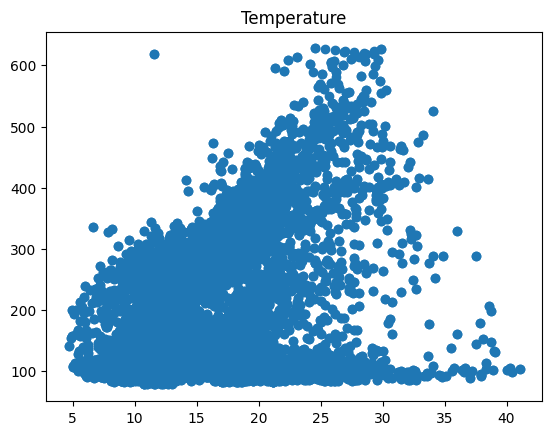

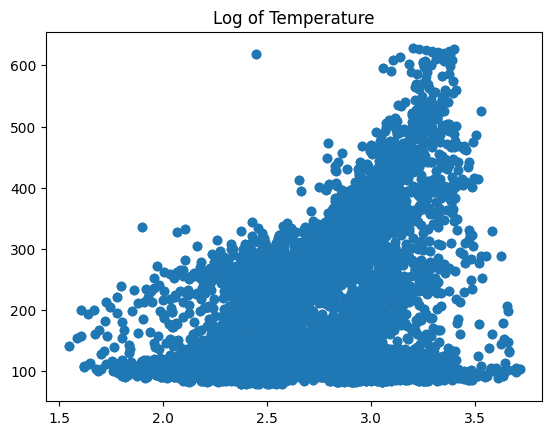

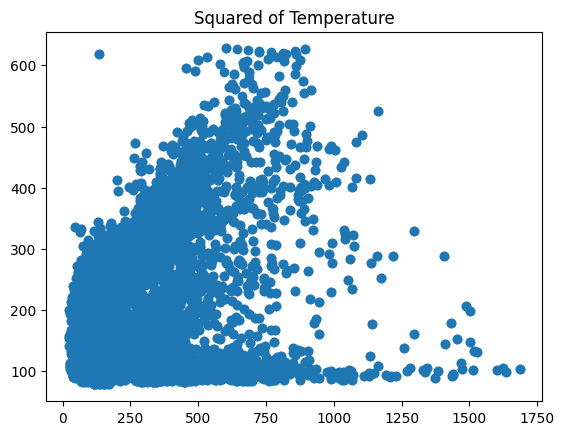

In [1609]:

plt.scatter(merged_df['temp_C'], merged_df['Power_kW'])
plt.title("Temperature")
plt.show()

plt.scatter(np.log(merged_df['temp_C']),merged_df['Power_kW'])
plt.title("Log of Temperature")
plt.show()


plt.scatter(merged_df['temp_C']**2,merged_df['Power_kW'])
plt.title("Squared of Temperature")
plt.show()


### Feature Engineering

In [1610]:
import pytz


merged_df.insert(1, "Year", merged_df.index.year)   # Insert at the first position
merged_df.insert(2, "Month", merged_df.index.month) # Insert at the second position
merged_df.insert(3, "Day", merged_df.index.day)     # Insert at the third position
merged_df.insert(4, "Hour", merged_df.index.hour)   # Insert at the fourth position

merged_df["Weekday"] = merged_df.index.weekday  # 0 = Monday, 6 = Sunday
merged_df["Is_Weekend"] = merged_df.index.weekday.isin([5, 6]).astype(int)  # 1 if Saturday/Sunday, else 0


merged_df["Hour_sin"] = np.sin(2 * np.pi * merged_df["Hour"] / 24)
merged_df["Hour_cos"] = np.cos(2 * np.pi * merged_df["Hour"] / 24)

merged_df["Power_kW_lag_1h"] = merged_df["Power_kW"].shift(1)
merged_df["Power_kW_lag_2h"] = merged_df["Power_kW"].shift(2)
merged_df["Power_kW_lag_24h"] = merged_df["Power_kW"].shift(24)

merged_df["HDH"] = np.maximum(0,-merged_df["temp_C"]+16) # heating degree hours
merged_df["CDH"] = np.maximum(0, merged_df["temp_C"] - 25) # Coling degree hours

merged_df["HDH_squared"] = merged_df["HDH"] ** 2 # heating degree hours


merged_df["CDH_squared"] = merged_df["CDH"] ** 2 # squared of CDH


merged_df["CDH_Humidity"] = merged_df["CDH"] * merged_df["HR"] # try relationship with humidity



merged_df["log_temp"] = np.log(merged_df["temp_C"])
merged_df["temp_squared"] = merged_df["temp_C"]



# dia do tecnico -> 23/05
# feriados

"""

2017
1 de janeiro – Ano Novo
28 de fevereiro – Carnaval (facultativo)
14 de abril – Sexta-feira Santa
16 de abril – Páscoa -> foi domingo
25 de abril – Dia da Liberdade
1 de maio – Dia do Trabalhador
10 de junho – Dia de Portugal
15 de junho – Corpo de Deus
13 de junho – Santo António (feriado municipal de Lisboa)
15 de agosto – Assunção de Nossa Senhora
5 de outubro – Implantação da República
1 de novembro – Dia de Todos os Santos
1 de dezembro – Restauração da Independência
8 de dezembro – Imaculada Conceição
25 de dezembro – Natal


2018
1 de janeiro – Ano Novo
13 de fevereiro – Carnaval (facultativo)
30 de março – Sexta-feira Santa
1 de abril – Páscoa
25 de abril – Dia da Liberdade
1 de maio – Dia do Trabalhador
10 de junho – Dia de Portugal
31 de maio – Corpo de Deus
13 de junho – Santo António (feriado municipal de Lisboa)
15 de agosto – Assunção de Nossa Senhora
5 de outubro – Implantação da República
1 de novembro – Dia de Todos os Santos
1 de dezembro – Restauração da Independência
8 de dezembro – Imaculada Conceição
25 de dezembro – Natal
"""

holidays = {
    1: {"2017-1-1"},
    2 : {"2017-2-5", "2017-2-19"},
    3 : {"2017-2-27","2017-2-28"},
    4 : {"2017-4-10","2017-4-14"},
    5 : {"2017-4-16"},
    6 : {"2017-4-25"},
    7 : {"2017-5-1"},
    8 : {"2017-6-10"},
    9 : {"2017-6-13"},
    10 : {"2017-6-15"},
    11 : {"2017-7-29" , "2017-9-10"},
    12 : {"2017-10-5"},
    13 : {"2017-11-1"},
    14 : {"2017-12-1"},
    15 : {"2017-12-8"},
    16 : {"2017-12-8"},
    17 : {"2017-12-23" , "2018-1-1"},
    18 : {"2018-2-4", "2018-2-18"},
    19 : {"2018-3-26","2018-4-1"},
    20 : {"2018-4-25"},
    21 : {"2018-5-1"},
    22 : {"2018-5-23"},
    23 : {"2018-5-31"},
    24 : {"2018-6-10"},
    25 : {"2018-6-13"},
    26 : {"2018-7-28","2018-9-9"},
    27 : {"2018-10-5"},
    28 : {"2018-11-1"},
    29 : {"2018-12-1"},
    30 : {"2018-12-22" , "2018-12-31"}
}



def expand_holiday_dates(holidays):
    expanded_dates = set()
    
    for dates_set in holidays.values():
        date_list = sorted(pd.to_datetime(list(dates_set)))  # Convert to datetime and sort
        
        if len(date_list) == 1:  # Single date case
            expanded_dates.add(date_list[0].date())
        elif len(date_list) == 2:  # Range case (two dates given)
            expanded_dates.update(pd.date_range(date_list[0], date_list[1]).date)  # Expand range
    
    return expanded_dates

holiday_dates = expand_holiday_dates(holidays)



merged_df['holiday'] = merged_df.index.to_series().apply(lambda x: x.date()).isin(holiday_dates)



print(merged_df.info())

merged_df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17350 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Power_kW          17350 non-null  float64
 1   Year              17350 non-null  int32  
 2   Month             17350 non-null  int32  
 3   Day               17350 non-null  int32  
 4   Hour              17350 non-null  int32  
 5   temp_C            17350 non-null  float64
 6   HR                17350 non-null  float64
 7   solarRad_W/m2     17350 non-null  float64
 8   Weekday           17350 non-null  int32  
 9   Is_Weekend        17350 non-null  int32  
 10  Hour_sin          17350 non-null  float64
 11  Hour_cos          17350 non-null  float64
 12  Power_kW_lag_1h   17349 non-null  float64
 13  Power_kW_lag_2h   17348 non-null  float64
 14  Power_kW_lag_24h  17326 non-null  float64
 15  HDH               17350 non-null  float64
 16  CDH  

Power_kW  Year  Month  Day  Hour     temp_C         HR  \
Date_start                                                                     
2017-01-01 00:00:00  80.047693  2017      1    1     0  11.686667  67.979167   
2017-01-01 01:00:00  81.376392  2017      1    1     1  11.239167  70.430000   
2017-01-01 02:00:00  79.450315  2017      1    1     2  10.735833  75.283333   
2017-01-01 03:00:00  78.523656  2017      1    1     3  10.744167  76.466667   
2017-01-01 04:00:00  78.947765  2017      1    1     4  11.012500  76.475000   

                     solarRad_W/m2  Weekday  Is_Weekend  ...  Power_kW_lag_2h  \
Date_start                                               ...                    
2017-01-01 00:00:00       1.100750        6           1  ...              NaN   
2017-01-01 01:00:00       0.941667        6           1  ...              NaN   
2017-01-01 02:00:00       0.734083        6           1  ...        80.047693   
2017-01-01 03:00:00       1.237500        6           1  ...        81.376392   
2017-01-01 04:00:00       1.288167        6           1  ...        79.450315   

                     Power_kW_lag_24h       HDH  CDH  HDH_squared  \
Date_start                                                          
2017-01-01 00:00:00               NaN  4.313333  0.0    18.604844   
2017-01-01 01:00:00               NaN  4.760833  0.0    22.665534   
2017-01-01 02:00:00               NaN  5.264167  0.0    27.711451   
2017-01-01 03:00:00               NaN  5.255833  0.0    27.623784   
2017-01-01 04:00:00               NaN  4.987500  0.0    24.875156   

                     CDH_squared  CDH_Humidity  log_temp  temp_squared  \
Date_start                                                               
2017-01-01 00:00:00          0.0           0.0  2.458449     11.686667   
2017-01-01 01:00:00          0.0           0.0  2.419405     11.239167   
2017-01-01 02:00:00          0.0           0.0  2.373587     10.735833   
2017-01-01 03:00:00          0.0           0.0  2.374363     10.744167   
2017-01-01 04:00:00          0.0           0.0  2.399031     11.012500   

                     holiday  
Date_start                    
2017-01-01 00:00:00     True  
2017-01-01 01:00:00     True  
2017-01-01 02:00:00     True  
2017-01-01 03:00:00     True  
2017-01-01 04:00:00     True  

[5 rows x 23 columns]

We can See that all the 3 lag features are important. 

We also can see that hour sin and hour cos are overall important too. 

We can also see that using log of temp, temp squared or temp is almost the same, doesn't change to much. 

Hour makes sense to drop because we already are using sin and cos of the hour.

Month, Year and Day are don't needed overall. Solar radiation, HR, HDH and CDH_Humidity also look like important features. 

Is weekend in some cases is better then Weekday and in others it isn't. So, we ran all the jupyter notebook for just weekend and both together and we got worst results then just weekday.

One thing that is suspicious is that mutual information, which measures how much knowing the feature reduces uncertainty in the target, is giving a considered low value to holidays. This is suspicious since the academic calendar should be a important feature.

F-test:

Feature Importance Ranking:
1. Power_kW_lag_1h: 81674.5820
2. Power_kW_lag_2h: 31981.0072
3. Power_kW_lag_24h: 20737.5676
4. Hour_cos: 10822.4612
5. solarRad_W/m2: 9451.2588
6. temp_squared: 2676.5059
7. temp_C: 2676.5059
8. log_temp: 2497.8241
9. HR: 1913.4673
10. HDH: 1441.3707
11. Is_Weekend: 1188.0934
12. Weekday: 1078.7739
13. HDH_squared: 928.3000
14. CDH_Humidity: 608.1576
15. Hour_sin: 591.9416
16. Hour: 474.7141
17. CDH: 257.0812
18. holiday: 187.6854
19. Month: 120.6874
20. CDH_squared: 18.7388
21. Day: 10.7042
22. Year: 0.0000


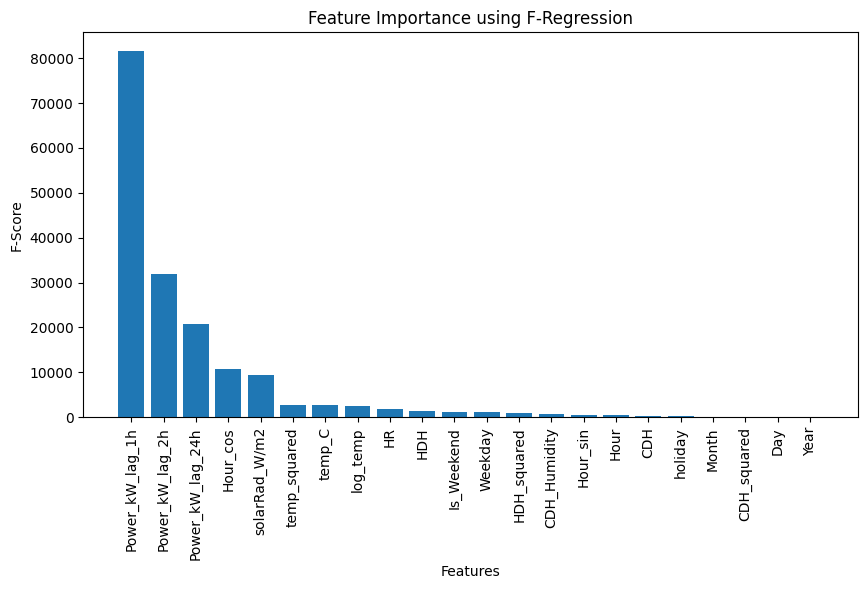


 Mutual Information:

Feature Ranking (Mutual Information):
1. Power_kW_lag_1h: 2.0244
2. Power_kW_lag_2h: 1.6835
3. Power_kW_lag_24h: 1.5533
4. Hour: 1.1629
5. solarRad_W/m2: 1.0972
6. temp_squared: 1.0408
7. temp_C: 1.0406
8. log_temp: 1.0340
9. Hour_cos: 0.9605
10. Month: 0.8663
11. HR: 0.8602
12. Hour_sin: 0.7701
13. Day: 0.7665
14. HDH: 0.6735
15. HDH_squared: 0.6665
16. holiday: 0.1682
17. CDH: 0.1113
18. CDH_Humidity: 0.1096
19. CDH_squared: 0.1064
20. Is_Weekend: 0.0819
21. Weekday: 0.0184
22. Year: 0.0000


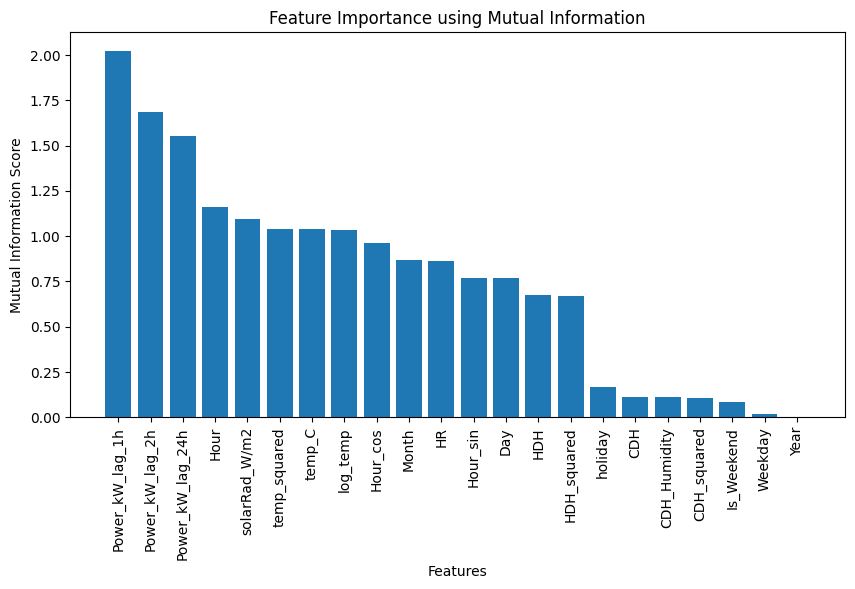


 RFE (Recursive Feature Elimination):

Feature Ranking (RFE):
1. Hour_cos: Rank 1
2. temp_squared: Rank 1
3. temp_C: Rank 1
4. Is_Weekend: Rank 2
5. log_temp: Rank 3
6. holiday: Rank 4
7. Hour_sin: Rank 5
8. CDH: Rank 6
9. Weekday: Rank 7
10. Power_kW_lag_1h: Rank 8
11. Hour: Rank 9
12. HDH_squared: Rank 10
13. Power_kW_lag_24h: Rank 11
14. HDH: Rank 12
15. CDH_squared: Rank 13
16. CDH_Humidity: Rank 14
17. Year: Rank 15
18. Power_kW_lag_2h: Rank 16
19. Day: Rank 17
20. Month: Rank 18
21. HR: Rank 19
22. solarRad_W/m2: Rank 20


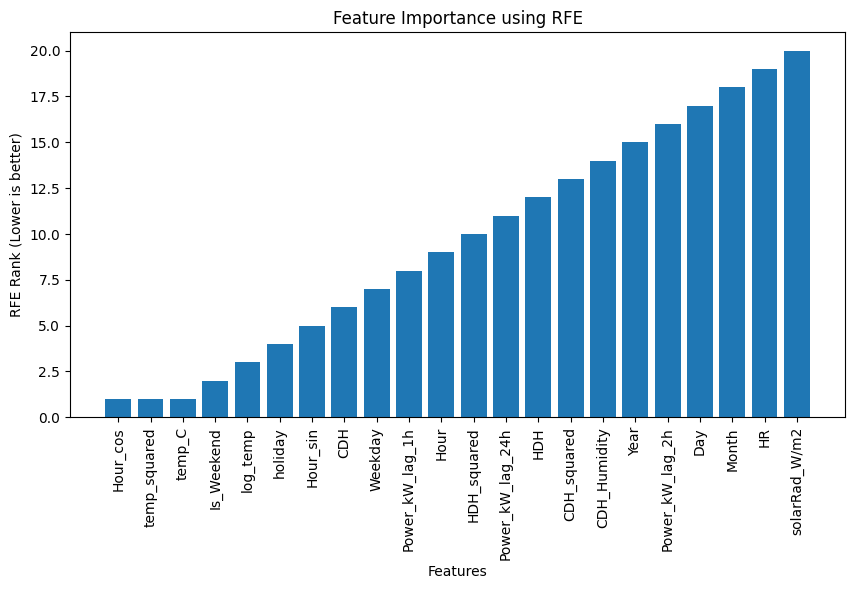


 Random Forest Feature Importance:

Feature Ranking (Random Forest):
1. Power_kW_lag_1h: 0.8172
2. Power_kW_lag_24h: 0.0589
3. Hour_cos: 0.0244
4. Power_kW_lag_2h: 0.0182
5. Hour: 0.0166
6. Hour_sin: 0.0162
7. Weekday: 0.0133
8. solarRad_W/m2: 0.0095
9. HR: 0.0043
10. temp_C: 0.0035
11. temp_squared: 0.0033
12. log_temp: 0.0033
13. Day: 0.0031
14. Month: 0.0025
15. HDH_squared: 0.0013
16. CDH_Humidity: 0.0011
17. HDH: 0.0010
18. holiday: 0.0010
19. Is_Weekend: 0.0004
20. CDH: 0.0004
21. CDH_squared: 0.0003
22. Year: 0.0002


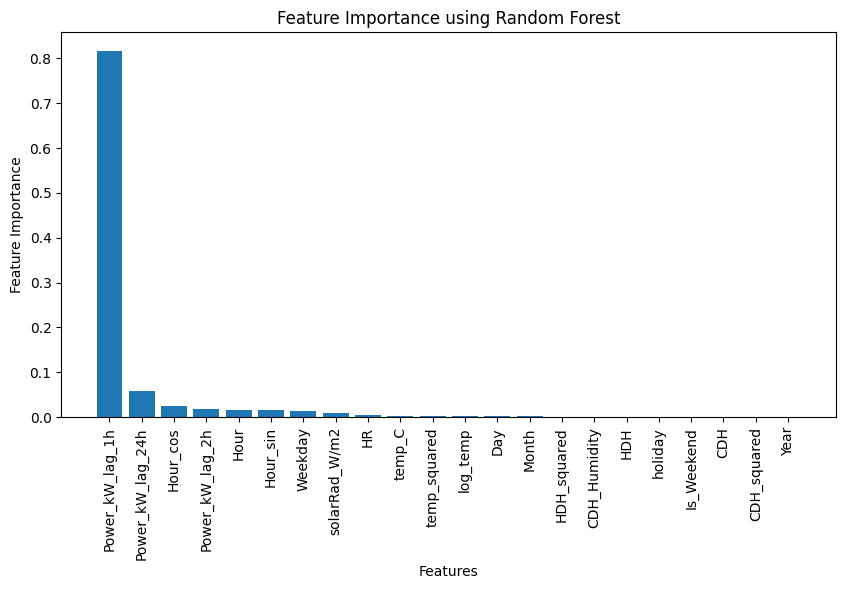

'\nimport shap\n\nmodel = LinearRegression()\nmodel.fit(merged_copy[features],merged_copy[\'Power_kW\'])\n\nexplainer = shap.Explainer(model)\n\nshap_values = explainer.shap_values(merged_copy[features])\n\nfeature_importances = np.abs(shap_values).mean(axis=0)\n\nsorted_features = merged_copy[features].columns[np.argsort(feature_importances)[::-1]]\n\nk = 8 \nselected_features = sorted_features[:k]\n\nprint("Selected features:")\nprint(selected_features)\n'

In [1611]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# -----------------------------
# F-TEST
# -----------------------------


print("F-test:")

features = merged_df.columns.drop(["Power_kW"]).tolist()

merged_copy = merged_df.dropna()

# Apply SelectKBest
feature_selector = SelectKBest(k=3, score_func=f_regression)
fit = feature_selector.fit(merged_copy[features], merged_copy["Power_kW"])

feature_scores = fit.scores_
feature_names = np.array(features)

sorted_indices = np.argsort(feature_scores)[::-1]  # Descending order
sorted_features = feature_names[sorted_indices]
sorted_scores = feature_scores[sorted_indices]

print("\nFeature Importance Ranking:")
for i, (feature, score) in enumerate(zip(sorted_features, sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_scores)
plt.xticks(rotation=90)  
plt.xlabel("Features")
plt.ylabel("F-Score")
plt.title("Feature Importance using F-Regression")
plt.show()



# -----------------------------
# Mutual Information
# -----------------------------
print("\n Mutual Information:")

mi_selector = SelectKBest(k=3, score_func=mutual_info_regression)
mi_fit = mi_selector.fit(merged_copy[features], merged_copy["Power_kW"])

mi_scores = mi_fit.scores_
mi_sorted_indices = np.argsort(mi_scores)[::-1]  # Sort descending
mi_sorted_features = np.array(features)[mi_sorted_indices]
mi_sorted_scores = mi_scores[mi_sorted_indices]

print("\nFeature Ranking (Mutual Information):")
for i, (feature, score) in enumerate(zip(mi_sorted_features, mi_sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(mi_sorted_features, mi_sorted_scores)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Feature Importance using Mutual Information")
plt.show()

# -----------------------------
# RFE (Recursive Feature Elimination)
# -----------------------------
print("\n RFE (Recursive Feature Elimination):")

estimator = LinearRegression()
rfe_selector = RFE(estimator, n_features_to_select=3)
rfe_selector.fit(merged_copy[features], merged_copy["Power_kW"])

rfe_ranking = rfe_selector.ranking_
rfe_sorted_indices = np.argsort(rfe_ranking)  # Lower rank = more important
rfe_sorted_features = np.array(features)[rfe_sorted_indices]
rfe_sorted_scores = rfe_ranking[rfe_sorted_indices]

print("\nFeature Ranking (RFE):")
for i, (feature, rank) in enumerate(zip(rfe_sorted_features, rfe_sorted_scores)):
    print(f"{i+1}. {feature}: Rank {rank}")

plt.figure(figsize=(10, 5))
plt.bar(rfe_sorted_features, rfe_sorted_scores)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("RFE Rank (Lower is better)")
plt.title("Feature Importance using RFE")
plt.show()

# -----------------------------
# Ensemble RF (Random Forest)
# -----------------------------
print("\n Random Forest Feature Importance:")

rf_model = RandomForestRegressor()
rf_model.fit(merged_copy[features], merged_copy["Power_kW"])

rf_importances = rf_model.feature_importances_
rf_sorted_indices = np.argsort(rf_importances)[::-1]  # Sort descending
rf_sorted_features = np.array(features)[rf_sorted_indices]
rf_sorted_scores = rf_importances[rf_sorted_indices]

print("\nFeature Ranking (Random Forest):")
for i, (feature, score) in enumerate(zip(rf_sorted_features, rf_sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 5))
plt.bar(rf_sorted_features, rf_sorted_scores)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance using Random Forest")
plt.show()

 

#--------------------------------------------------------------
# SHAP (really SLOW)
# Spent ~3hours and didn't run, even using just a few features
#--------------------------------------------------------------

"""
import shap

model = LinearRegression()
model.fit(merged_copy[features],merged_copy['Power_kW'])

explainer = shap.Explainer(model)

shap_values = explainer.shap_values(merged_copy[features])

feature_importances = np.abs(shap_values).mean(axis=0)

sorted_features = merged_copy[features].columns[np.argsort(feature_importances)[::-1]]

k = 8 
selected_features = sorted_features[:k]

print("Selected features:")
print(selected_features)
"""

Correlation Matrix

The correlation Matrix confirms what we said above. We can see that holiday and temp_squared is highly correlated, meaning that they are redundant. Then, we are going to use log_temp. Oh the other hand we can see that holidays are not that related to the power consumption as we expected. We tried to run with and without this feature and we got better results when running with , so we will keep it (also because using our intuiton makes sense to use the calendar academic as feature). We are now ready to drop all the features that we don't want.

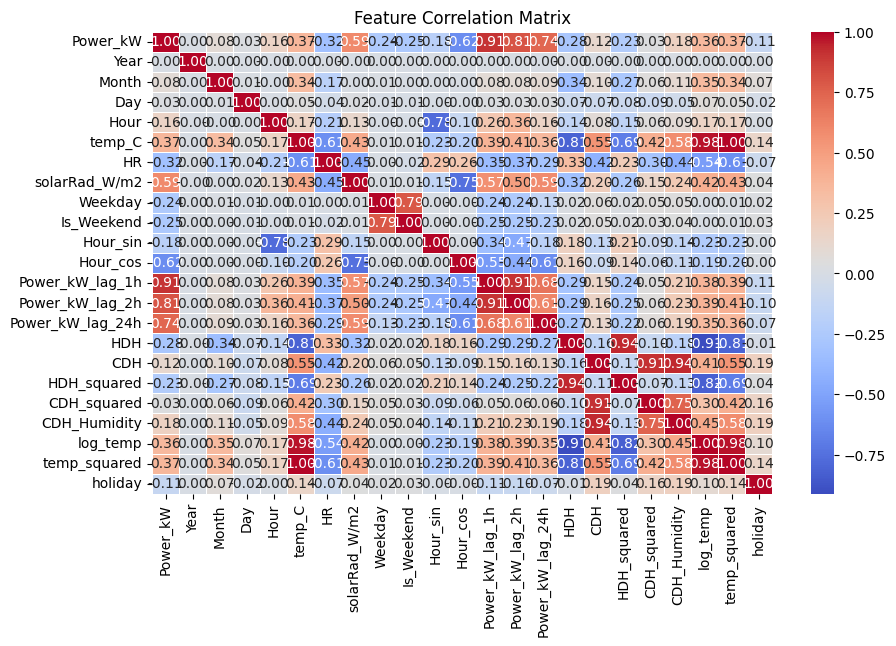

In [1612]:
correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

Features Drop

In [1613]:
merged_df = merged_df.drop(columns = ['Month','Year','Day','Hour','CDH',"temp_C","temp_squared","HDH_squared", "Is_Weekend"])

merged_df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17350 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Power_kW          17350 non-null  float64
 1   HR                17350 non-null  float64
 2   solarRad_W/m2     17350 non-null  float64
 3   Weekday           17350 non-null  int32  
 4   Hour_sin          17350 non-null  float64
 5   Hour_cos          17350 non-null  float64
 6   Power_kW_lag_1h   17349 non-null  float64
 7   Power_kW_lag_2h   17348 non-null  float64
 8   Power_kW_lag_24h  17326 non-null  float64
 9   HDH               17350 non-null  float64
 10  CDH_squared       17350 non-null  float64
 11  CDH_Humidity      17350 non-null  float64
 12  log_temp          17350 non-null  float64
 13  holiday           17350 non-null  bool   
dtypes: bool(1), float64(12), int32(1)
memory usage: 1.8 MB


Handling the NaN generated by the lag features

In [1614]:
merged_df["Power_kW_lag_1h"] = merged_df["Power_kW_lag_1h"].interpolate(method='linear', limit_direction='both')
merged_df["Power_kW_lag_2h"] = merged_df["Power_kW_lag_2h"].interpolate(method='linear', limit_direction='both')

merged_df["Power_kW_lag_24h"] = merged_df["Power_kW_lag_24h"].fillna(merged_df["Power_kW"].shift(-24))

print(merged_df.info())

merged_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17350 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Power_kW          17350 non-null  float64
 1   HR                17350 non-null  float64
 2   solarRad_W/m2     17350 non-null  float64
 3   Weekday           17350 non-null  int32  
 4   Hour_sin          17350 non-null  float64
 5   Hour_cos          17350 non-null  float64
 6   Power_kW_lag_1h   17350 non-null  float64
 7   Power_kW_lag_2h   17350 non-null  float64
 8   Power_kW_lag_24h  17350 non-null  float64
 9   HDH               17350 non-null  float64
 10  CDH_squared       17350 non-null  float64
 11  CDH_Humidity      17350 non-null  float64
 12  log_temp          17350 non-null  float64
 13  holiday           17350 non-null  bool   
dtypes: bool(1), float64(12), int32(1)
memory usage: 1.8 MB
None


Power_kW         HR  solarRad_W/m2  Weekday  Hour_sin  \
Date_start                                                                    
2017-01-01 00:00:00  80.047693  67.979167       1.100750        6  0.000000   
2017-01-01 01:00:00  81.376392  70.430000       0.941667        6  0.258819   
2017-01-01 02:00:00  79.450315  75.283333       0.734083        6  0.500000   
2017-01-01 03:00:00  78.523656  76.466667       1.237500        6  0.707107   
2017-01-01 04:00:00  78.947765  76.475000       1.288167        6  0.866025   

                     Hour_cos  Power_kW_lag_1h  Power_kW_lag_2h  \
Date_start                                                        
2017-01-01 00:00:00  1.000000        80.047693        80.047693   
2017-01-01 01:00:00  0.965926        80.047693        80.047693   
2017-01-01 02:00:00  0.866025        81.376392        80.047693   
2017-01-01 03:00:00  0.707107        79.450315        81.376392   
2017-01-01 04:00:00  0.500000        78.523656        79.450315   

                     Power_kW_lag_24h       HDH  CDH_squared  CDH_Humidity  \
Date_start                                                                   
2017-01-01 00:00:00         80.025188  4.313333          0.0           0.0   
2017-01-01 01:00:00         80.615793  4.760833          0.0           0.0   
2017-01-01 02:00:00         80.941577  5.264167          0.0           0.0   
2017-01-01 03:00:00         85.234447  5.255833          0.0           0.0   
2017-01-01 04:00:00         78.660000  4.987500          0.0           0.0   

                     log_temp  holiday  
Date_start                              
2017-01-01 00:00:00  2.458449     True  
2017-01-01 01:00:00  2.419405     True  
2017-01-01 02:00:00  2.373587     True  
2017-01-01 03:00:00  2.374363     True  
2017-01-01 04:00:00  2.399031     True

Saving the data

In [1615]:

merged_df = merged_df.reset_index().rename(columns={"index": "Date_start"})


merged_df.to_csv('Power_Cleaned.csv', encoding='utf-8', index=False)

# Regression


In [1492]:
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import statsmodels.api as sm

merged_df = pd.read_csv(r'Power_Cleaned.csv')

merged_df = merged_df.set_index('Date_start') # make 'datetime' into index

merged_df.index = pd.to_datetime(merged_df.index)


merged_df.head()

Power_kW         HR  solarRad_W/m2  Weekday  Hour_sin  \
Date_start                                                                    
2017-01-01 00:00:00  80.047693  67.979167       1.100750        6  0.000000   
2017-01-01 01:00:00  81.376392  70.430000       0.941667        6  0.258819   
2017-01-01 02:00:00  79.450315  75.283333       0.734083        6  0.500000   
2017-01-01 03:00:00  78.523656  76.466667       1.237500        6  0.707107   
2017-01-01 04:00:00  78.947765  76.475000       1.288167        6  0.866025   

                     Hour_cos  Power_kW_lag_1h  Power_kW_lag_2h  \
Date_start                                                        
2017-01-01 00:00:00  1.000000        80.047693        80.047693   
2017-01-01 01:00:00  0.965926        80.047693        80.047693   
2017-01-01 02:00:00  0.866025        81.376392        80.047693   
2017-01-01 03:00:00  0.707107        79.450315        81.376392   
2017-01-01 04:00:00  0.500000        78.523656        79.450315   

                     Power_kW_lag_24h       HDH  CDH_squared  CDH_Humidity  \
Date_start                                                                   
2017-01-01 00:00:00         80.025188  4.313333          0.0           0.0   
2017-01-01 01:00:00         80.615793  4.760833          0.0           0.0   
2017-01-01 02:00:00         80.941577  5.264167          0.0           0.0   
2017-01-01 03:00:00         85.234447  5.255833          0.0           0.0   
2017-01-01 04:00:00         78.660000  4.987500          0.0           0.0   

                     log_temp  holiday  
Date_start                              
2017-01-01 00:00:00  2.458449     True  
2017-01-01 01:00:00  2.419405     True  
2017-01-01 02:00:00  2.373587     True  
2017-01-01 03:00:00  2.374363     True  
2017-01-01 04:00:00  2.399031     True

## Evaluation Metrics

**1. MAE (Mean Absolute Error)**
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |
$$
- Measures the **average absolute difference** between actual values $( y_i $) and predicted values ($ \hat{y}_i $).
- **Lower values** indicate better accuracy.
- **Example Interpretation:** If **MAE = 5**, the model's predictions are, on average, **5 units off**.

---

**2. MBE (Mean Bias Error)**
$$
MBE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)
$$
- Measures the **average bias** in predictions.
- **Positive MBE** → Model **underestimates** the true values.
- **Negative MBE** → Model **overestimates** the true values.
- **Ideal value:** Close to **0** (no systematic bias).

---

**3. MSE (Mean Squared Error)**
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
- Similar to MAE but **squares the errors** to penalize large deviations more.
- **Lower values** indicate better model performance.
- **Sensitive to outliers**, as larger errors have a greater impact.

---

**4. RMSE (Root Mean Squared Error)**
$$
RMSE = \sqrt{MSE}
$$
- The **square root** of MSE, keeping the unit the same as the target variable.
- More interpretable than MSE.
- **Smaller RMSE** indicates better accuracy.

---
**5. cvRMSE (Coefficient of Variation of RMSE)**
$$
cvRMSE = \frac{RMSE}{\bar{y}} \times 100
$$
- Expresses **RMSE as a percentage** of the mean observed value.
- Helps compare models with different scales.
- **Lower cvRMSE** means the model performs well relative to the scale of the data.

---
**6. NMBE (Normalized Mean Bias Error)**
$$
NMBE = \frac{MBE}{\bar{y}} \times 100
$$
- Normalized version of **MBE**, expressed as a percentage.
- Indicates whether the model has **systematic bias**.
- **If NMBE > 0**, the model underpredicts; **if NMBE < 0**, the model overpredicts.



---



 **Summary Table**

| Metric   | Purpose | Ideal Value |
|----------|---------|------------|
| **MAE**  | Measures average absolute error | Close to 0 |
| **MBE**  | Measures bias (positive = underpredict, negative = overpredict) | Close to 0 |
| **MSE**  | Penalizes large errors (squared) | Close to 0 |
| **RMSE** | Square root of MSE, interpretable | Close to 0 |
| **cvRMSE** | RMSE as a percentage of mean | Lower is better |
| **NMBE**  | Bias as a percentage of mean | Close to 0 |





## Time Series Analysis

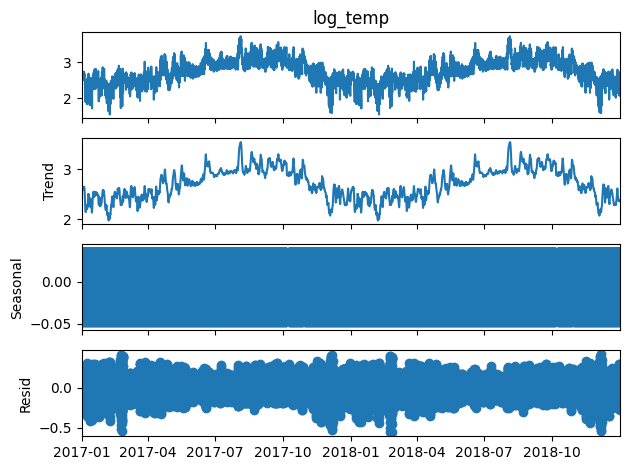

In [1493]:
res = sm.tsa.seasonal_decompose(merged_df['log_temp'],
                                period=24,
                                model='additive')
resplot = res.plot()

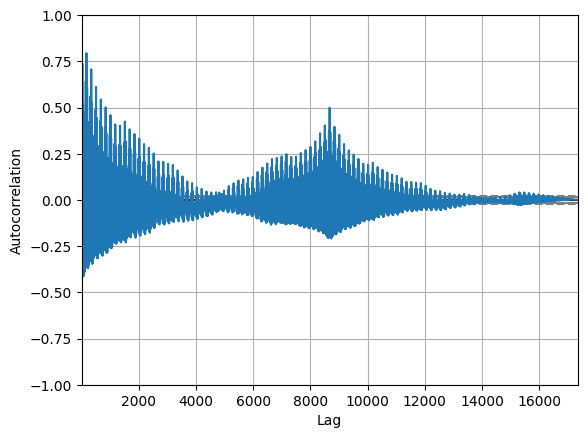

In [1494]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
autocorrelation_plot(merged_df['Power_kW'])
plt.show()

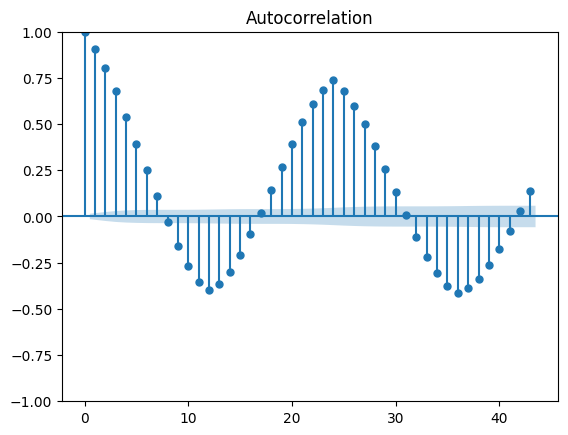

In [1495]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(merged_df['Power_kW'])
plt.show()

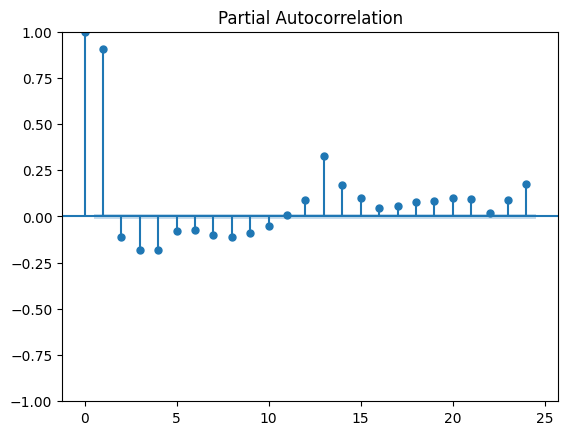

In [1496]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(merged_df['Power_kW'],lags=24) # one day=24 lags / one week 24*7=168 lags
plt.show()

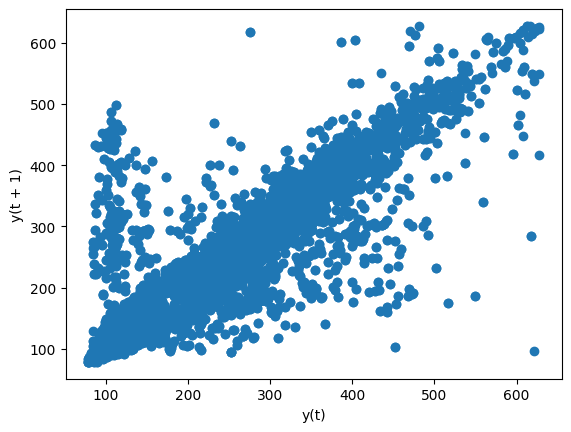

In [1497]:
from pandas.plotting import lag_plot
lag_plot(merged_df['Power_kW'])
plt.show()

## Auto-Regressive Models





### AR

Doesn't rely on features. Just predicts the next value having in mind the previous one.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\236696707.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history = [history[i] for i in range(len(history))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\236696707.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = coef[0]
C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\236696707.py:43: FutureWarni

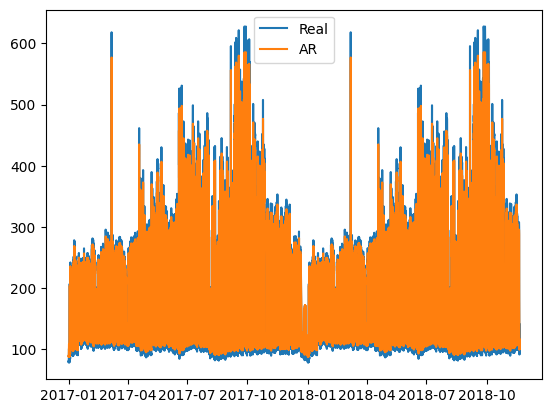

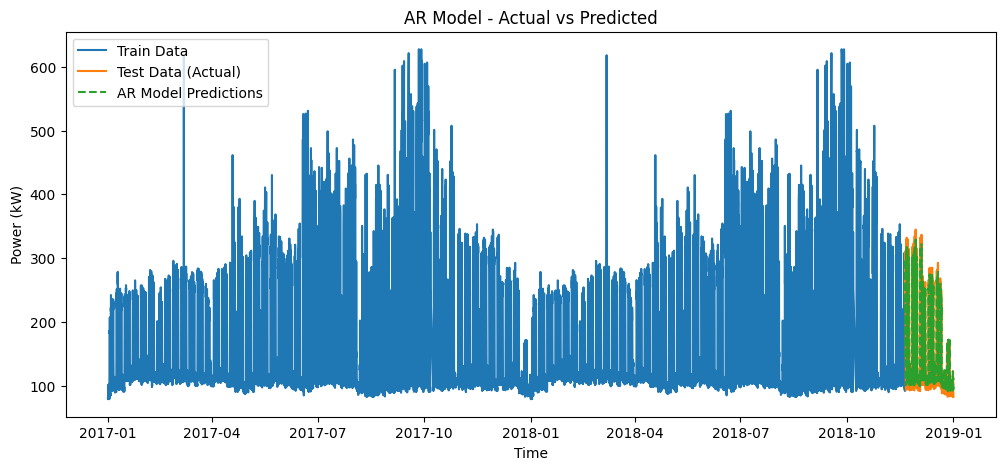

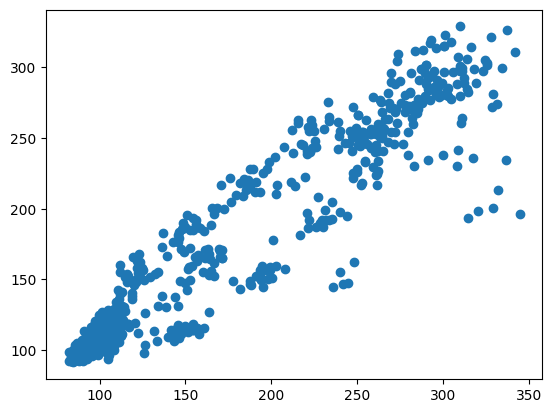

MAE_AR: 
15.097621727796001
MBE_AR: 
-2.6077624819676504
MSE_AR: 
481.6639270852629
RMSE_AR: 
21.946843214577875
cvRMSE_AR: 
0.14670099998817857
NMBE_AR: 
-0.017431270643160104


In [1498]:
from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

merged_df = merged_df.dropna()

# ------------------------
# Train Model
# ------------------------

Y=merged_df['Power_kW']

split_point = len(Y) - 1000
train, test = Y[0:split_point], Y[split_point:]
window = 1
model = AutoReg(train, lags=window)
#model=ARIMA(train, order=(1, 1,1))
model_fit = model.fit()

#print(model_fit.summary())

#model_fit.plot_predict()
plt.plot(train,label='Real')
plt.plot(model_fit.fittedvalues,label='AR')
plt.legend()

# ------------------------
# Evaluate with test data
# ------------------------


coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# Plot actual vs predicted values
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Test Data (Actual)")
plt.plot(test.index, predictions, label="AR Model Predictions", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("AR Model - Actual vs Predicted")
plt.legend()
plt.show()

plt.scatter(test,predictions)
plt.show()
# ------------------------
# Evaluation Metrics
# ------------------------

MAE_AR=metrics.mean_absolute_error(test,predictions)
MBE_AR=np.mean(test-predictions) #here we calculate MBE
MSE_AR=metrics.mean_squared_error(test,predictions)
RMSE_AR= np.sqrt(metrics.mean_squared_error(test,predictions))
cvRMSE_AR=RMSE_AR/np.mean(test)
NMBE_AR=MBE_AR/np.mean(test)

print("MAE_AR: ")
print(MAE_AR)
print("MBE_AR: ")
print(MBE_AR)
print("MSE_AR: ")
print(MSE_AR)
print("RMSE_AR: ")
print(RMSE_AR)
print("cvRMSE_AR: ")
print(cvRMSE_AR)
print("NMBE_AR: ")
print(NMBE_AR)



## Linear Regression

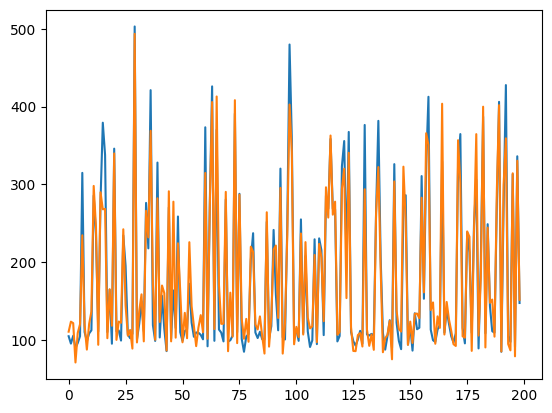

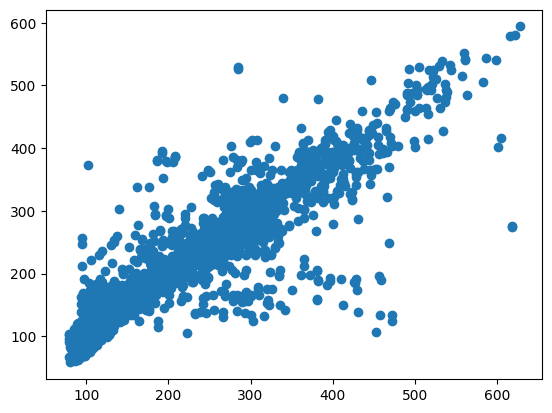

MAE_LR: 
21.316143039571234
MBE_LR: 
0.5121633279621445
MSE_LR: 
1431.1188629158175
RMSE_LR: 
37.83013167986358
cvRMSE_LR: 
0.2172686434604224
NMBE_LR: 
0.002941492047614037


In [1499]:
from sklearn import  linear_model

X = merged_df.drop(columns = ['Power_kW'])
Y = merged_df['Power_kW']

X_train, X_test, y_train, y_test = train_test_split(X,Y)


regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred_LR = regr.predict(X_test)


plt.plot(np.arange(199),y_test[1:200])
plt.plot(np.arange(199), y_pred_LR[1:200])
plt.show()
plt.scatter(y_test,y_pred_LR)
plt.show()


# ------------------------
# Evaluation Metrics
# ------------------------

MAE_LR=metrics.mean_absolute_error(y_test,y_pred_LR)
MBE_LR=np.mean(y_test- y_pred_LR) #here we calculate MBE
MSE_LR=metrics.mean_squared_error(y_test,y_pred_LR)
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test,y_pred_LR))
cvRMSE_LR=RMSE_LR/np.mean(y_test)
NMBE_LR=MBE_LR/np.mean(y_test)

print("MAE_LR: ")
print(MAE_LR)
print("MBE_LR: ")
print(MBE_LR)
print("MSE_LR: ")
print(MSE_LR)
print("RMSE_LR: ")
print(RMSE_LR)
print("cvRMSE_LR: ")
print(cvRMSE_LR)
print("NMBE_LR: ")
print(NMBE_LR)

## Support Vector Regressor

(13012,)


C:\Users\tomas\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


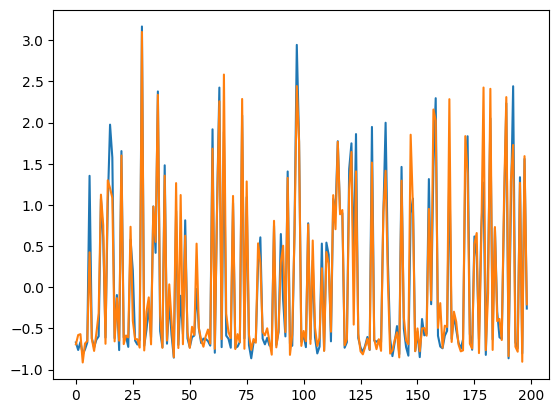

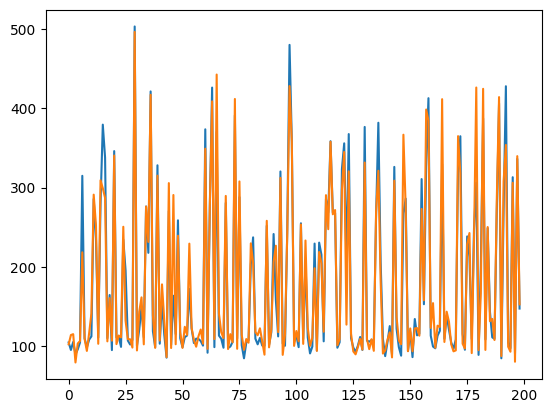

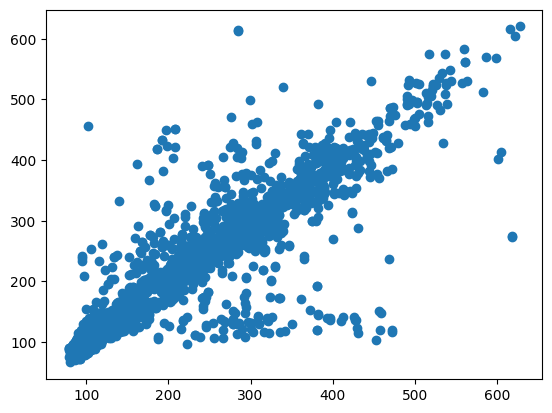

In [1500]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

ss_X = StandardScaler()
ss_y = StandardScaler()
X_train_ss = ss_X.fit_transform(X_train)
print(y_train.shape)
y_train_ss = ss_y.fit_transform(y_train.to_numpy().reshape(-1,1))

regr = SVR(kernel='linear')
#kernel='linear'
#kernel='sigmoid'
#kernel='rbf'

regr.fit(X_train_ss,y_train_ss)


y_pred_SVR = regr.predict(ss_X.fit_transform(X_test))
y_test_SVR=ss_y.fit_transform(y_test.to_numpy().reshape(-1,1))
y_pred_SVR2=ss_y.inverse_transform(y_pred_SVR.reshape(-1,1))


plt.plot(np.arange(199),y_test_SVR[1:200])
plt.plot(np.arange(199),y_pred_SVR[1:200])
plt.show()
plt.plot(np.arange(199),y_test[1:200])
plt.plot(np.arange(199),y_pred_SVR2[1:200])
plt.show()
plt.scatter(y_test, y_pred_SVR2)




In [1501]:

# ------------------------
# Evaluation Metrics
# ------------------------

y_pred_SVR2 = y_pred_SVR2.reshape(-1,)

MAE_SVR=metrics.mean_absolute_error(y_test, y_pred_SVR2)
MBE_SVR=np.mean(y_test- y_pred_SVR2) #here we calculate MBE
MSE_SVR=metrics.mean_squared_error(y_test,y_pred_SVR2)
RMSE_SVR= np.sqrt(metrics.mean_squared_error(y_test,y_pred_SVR2))
cvRMSE_SVR=RMSE_SVR/np.mean(y_test)
NMBE_SVR=MBE_SVR/np.mean(y_test)

print("MAE_SVR: ")
print(MAE_SVR)
print("MBE_SVR: ")
print(MBE_SVR)
print("MSE_SVR: ")
print(MSE_SVR)
print("RMSE_SVR: ")
print(RMSE_SVR)
print("cvRMSE_SVR: ")
print(cvRMSE_SVR)
print("NMBE_SVR: ")
print(NMBE_SVR)

MAE_SVR: 
18.88482316301242
MBE_SVR: 
1.1415542028406835
MSE_SVR: 
1645.178091457625
RMSE_SVR: 
40.56079500524645
cvRMSE_SVR: 
0.23295157899640576
NMBE_SVR: 
0.006556253496198076


## Gaussian Process Regressor

Very slow, if it is taking a very long time it's better to comment the next cell since it is not that important for the general understanding.

In [1502]:

import sklearn.gaussian_process as gp

kernel=gp.kernels.RBF(length_scale=1.0)
model = gp.GaussianProcessRegressor(kernel=kernel, alpha=0.1)


ss_X2 = StandardScaler()
ss_y2 = StandardScaler()
X2_train_ss = ss_X2.fit_transform(X_train)
y2_train_ss = ss_y2.fit_transform(y_train.to_numpy().reshape(-1,1))

model.fit(X2_train_ss, y2_train_ss)
params = model.kernel_.get_params()

y2_pred_GPR, sigma = model.predict(ss_X2.fit_transform(X_test), return_std=True)
y2_pred_GPR2=ss_y2.inverse_transform(y2_pred_GPR.reshape(1,-1))
y2_pred_GPR2_low=ss_y2.inverse_transform(y2_pred_GPR.reshape(1,-1)-sigma)
y2_pred_GPR2_high=ss_y2.inverse_transform(y2_pred_GPR.reshape(1,-1)+sigma)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


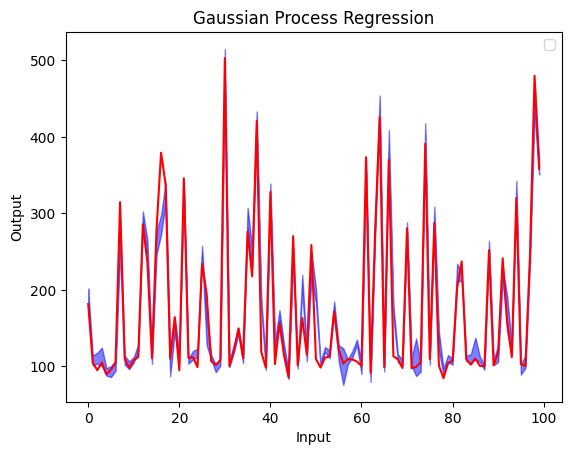

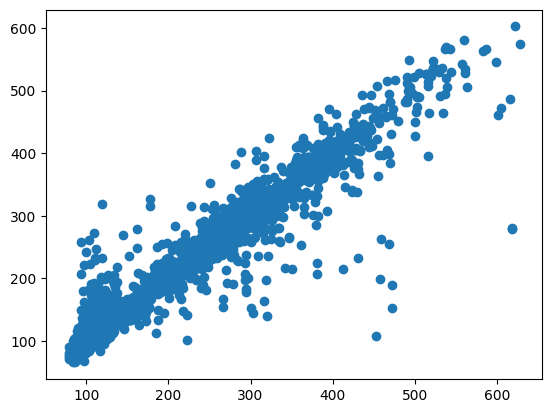

In [1503]:

plt.plot(np.arange(100),y_test[0:100], 'r-')
x2=np.arange(0, len(y_test),1)

y2_low=y2_pred_GPR2_low.reshape(-1)
y2_high=y2_pred_GPR2_high.reshape(-1)
plt.fill_between(x2[0:100],y2_low[0:100], y2_high[0:100], alpha=0.5, color='blue')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()
plt.scatter(y_test, y2_pred_GPR2)


In [1504]:

#---------------------
# Evaluation Metrics
#---------------------


MAE_GPR=metrics.mean_absolute_error(y_test,y2_pred_GPR2.reshape(-1))
MBE_GPR=np.mean(y_test- y2_pred_GPR2.reshape(-1)) #here we calculate MBE
MSE_GPR=metrics.mean_squared_error(y_test,y2_pred_GPR2.reshape(-1))
RMSE_GPR= np.sqrt(metrics.mean_squared_error(y_test,y2_pred_GPR2.reshape(-1)))
cvRMSE_GPR=RMSE_GPR/np.mean(y_test)
NMBE_GPR=MBE_GPR/np.mean(y_test)

print("MAE_GPR: ")
print(MAE_GPR)
print("MBE_GPR: ")
print(MBE_GPR)
print("MSE_GPR: ")
print(MSE_GPR)
print("RMSE_GPR: ")
print(RMSE_GPR)
print("cvRMSE_GPR: ")
print(cvRMSE_GPR)
print("NMBE_GPR: ")
print(NMBE_GPR)




MAE_GPR: 
11.83743291885756
MBE_GPR: 
-1.7453531942726437
MSE_GPR: 
621.1872810150905
RMSE_GPR: 
24.923628969616175
cvRMSE_GPR: 
0.14314311940980587
NMBE_GPR: 
-0.010024033859781158


## Decision Tree

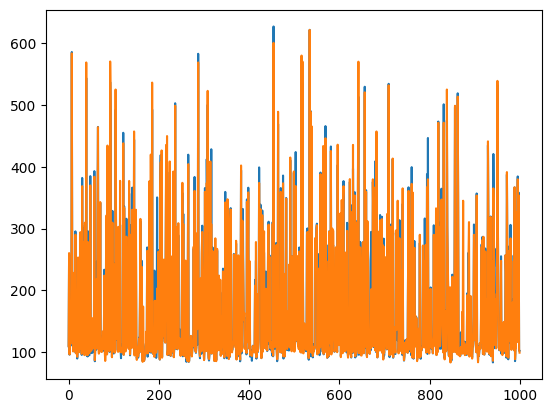

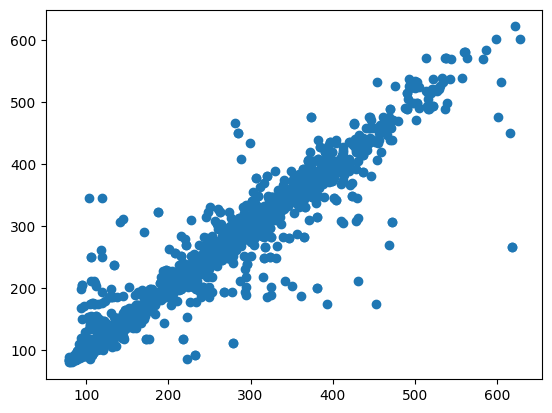

MAE_DT: 
9.046458734828166
MBE_DT: 
0.4528010376952723
MSE_DT: 
528.434287440407
RMSE_DT: 
22.987698611222633
cvRMSE_DT: 
0.13202454952584475
NMBE_DT: 
0.002600558413331914
9.046458734828166 0.4528010376952723 528.434287440407 22.987698611222633 0.13202454952584475 0.002600558413331914


In [1505]:
from sklearn.tree import DecisionTreeRegressor

DT_regr_model = DecisionTreeRegressor(min_samples_leaf=5)
DT_regr_model.fit(X_train, y_train)
y_pred_DT = DT_regr_model.predict(X_test)


plt.plot(np.arange(1000),y_test[1000:2000])
plt.plot(np.arange(1000),y_pred_DT[1000:2000])
plt.show()
plt.scatter(y_test,y_pred_DT)
plt.show()

#----------------------
# Evaluation Metrics
#----------------------

MAE_DT=metrics.mean_absolute_error(y_test,y_pred_DT)
MBE_DT=np.mean(y_test-y_pred_DT) #here we calculate MBE
MSE_DT=metrics.mean_squared_error(y_test,y_pred_DT)
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_DT))
cvRMSE_DT=RMSE_DT/np.mean(y_test)
NMBE_DT=MBE_DT/np.mean(y_test)

print("MAE_DT: ")
print(MAE_DT)
print("MBE_DT: ")
print(MBE_DT)
print("MSE_DT: ")
print(MSE_DT)
print("RMSE_DT: ")
print(RMSE_DT)
print("cvRMSE_DT: ")
print(cvRMSE_DT)
print("NMBE_DT: ")
print(NMBE_DT)



print(MAE_DT, MBE_DT,MSE_DT, RMSE_DT,cvRMSE_DT,NMBE_DT)

## Random Forest

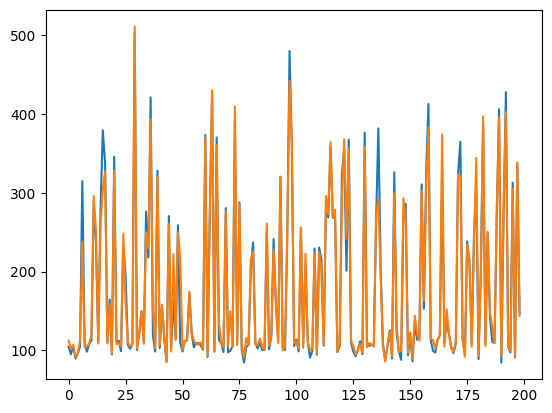

MAE_RF: 
9.467191194276099
MBE_RF: 
0.4528010376952723
MSE_RF: 
483.8502549619535
RMSE_RF: 
21.99659644040308
cvRMSE_RF: 
0.1263323826043306
NMBE_RF: 
0.002600558413331914


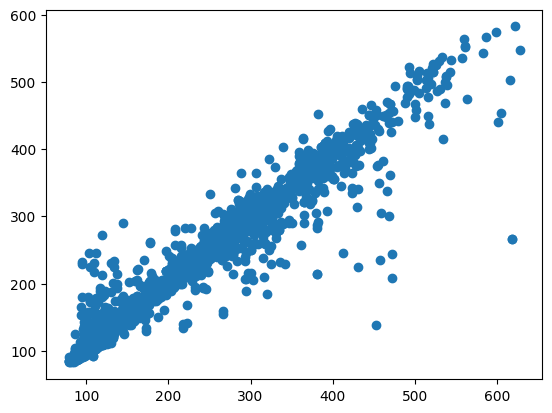

In [1506]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 200,
              'min_samples_split': 15,
              'max_features': 'sqrt',
              'max_depth': 20,
              'max_leaf_nodes': None}
RF_model = RandomForestRegressor(**parameters)
#RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
y_pred_RF = RF_model.predict(X_test)

plt.plot(np.arange(199),y_test[1:200])
plt.plot(np.arange(199),y_pred_RF[1:200])
plt.show()
plt.scatter(y_test,y_pred_RF)


#---------------------
# Evaluation Metrics
#---------------------

MAE_RF=metrics.mean_absolute_error(y_test,y_pred_RF)
MBE_RF=np.mean(y_test-y_pred_DT) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred_RF)
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred_RF))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)

print("MAE_RF: ")
print(MAE_RF)
print("MBE_RF: ")
print(MBE_RF)
print("MSE_RF: ")
print(MSE_RF)
print("RMSE_RF: ")
print(RMSE_RF)
print("cvRMSE_RF: ")
print(cvRMSE_RF)
print("NMBE_RF: ")
print(NMBE_RF)




## Gradient Boosting

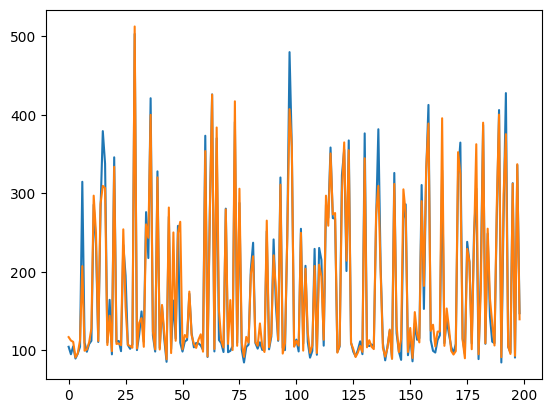

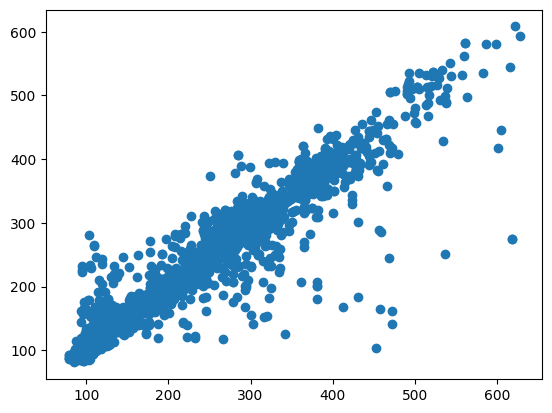

In [1507]:
from sklearn.ensemble import GradientBoostingRegressor

#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}
#GB_model = GradientBoostingRegressor(**params)

GB_model = GradientBoostingRegressor()
GB_model.fit(X_train, y_train)
y_pred_GB =GB_model.predict(X_test)

plt.plot(np.arange(199),y_test[1:200])
plt.plot(np.arange(199),y_pred_GB[1:200])
plt.show()
plt.scatter(y_test,y_pred_GB)

In [1508]:
MAE_GB=metrics.mean_absolute_error(y_test,y_pred_GB)
MBE_GB=np.mean(y_test-y_pred_GB)
MSE_GB=metrics.mean_squared_error(y_test,y_pred_GB)
RMSE_GB= np.sqrt(metrics.mean_squared_error(y_test,y_pred_GB))
cvRMSE_GB=RMSE_GB/np.mean(y_test)
NMBE_GB=MBE_GB/np.mean(y_test)

print("MAE_GB: ")
print(MAE_GB)
print("MBE_GB: ")
print(MBE_GB)
print("MSE_GB: ")
print(MSE_GB)
print("RMSE_GB: ")
print(RMSE_GB)
print("cvRMSE_GB: ")
print(cvRMSE_GB)
print("NMBE_GB: ")
print(NMBE_GB)




MAE_GB: 
12.83409630525376
MBE_GB: 
0.6092394105671806
MSE_GB: 
745.6532823850362
RMSE_GB: 
27.306652712938586
cvRMSE_GB: 
0.15682946711874687
NMBE_GB: 
0.00349902615715759


## Extreme Gradient Boosting (XGBoost)

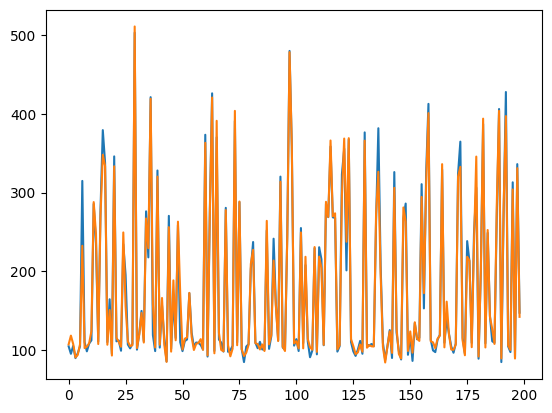

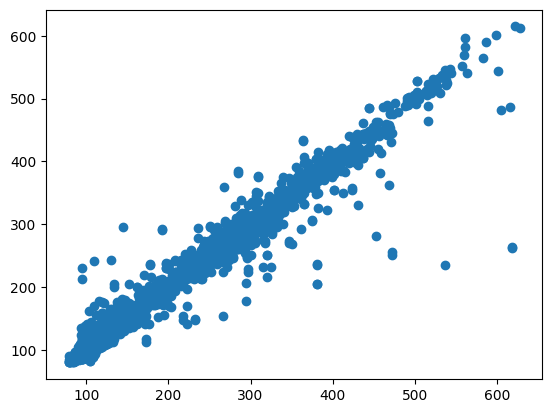

In [1509]:
from xgboost import XGBRegressor

#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}
#GB_model = GradientBoostingRegressor(**params)

XGB_model = XGBRegressor()

XGB_model.fit(X_train, y_train)
y_pred_XGB =XGB_model.predict(X_test)

plt.plot(np.arange(199), y_test[1:200])
plt.plot(np.arange(199), y_pred_XGB[1:200])
plt.show()
plt.scatter(y_test,y_pred_XGB)

In [1510]:
MAE_XGB=metrics.mean_absolute_error(y_test,y_pred_XGB)
MBE_XGB=np.mean(y_test-y_pred_XGB)
MSE_XGB=metrics.mean_squared_error(y_test,y_pred_XGB)
RMSE_XGB= np.sqrt(metrics.mean_squared_error(y_test,y_pred_XGB))
cvRMSE_XGB=RMSE_XGB/np.mean(y_test)
NMBE_XGB=MBE_XGB/np.mean(y_test)

print("MAE_XGB: ")
print(MAE_XGB)
print("MBE_XGB: ")
print(MBE_XGB)
print("MSE_XGB: ")
print(MSE_XGB)
print("RMSE_XGB: ")
print(RMSE_XGB)
print("cvRMSE_XGB: ")
print(cvRMSE_XGB)
print("NMBE_XGB: ")
print(NMBE_XGB)


MAE_XGB: 
7.841789729731114
MBE_XGB: 
0.4902727932541246
MSE_XGB: 
324.3387524776408
RMSE_XGB: 
18.009407332770305
cvRMSE_XGB: 
0.10343288080067552
NMBE_XGB: 
0.002815768806128034


## Bootstraping

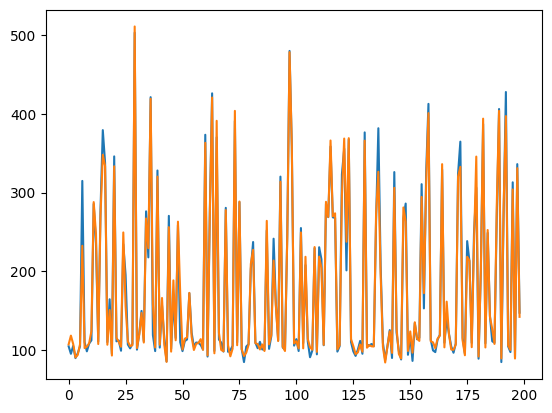

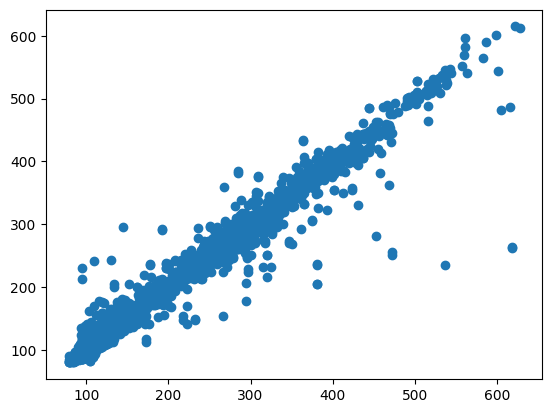

In [1511]:
from sklearn.ensemble import BaggingRegressor

BT_model = BaggingRegressor()
BT_model.fit(X_train, y_train)
y_pred_BT =BT_model.predict(X_test)

plt.plot(np.arange(199),y_test[1:200])
plt.plot(np.arange(199), y_pred_XGB[1:200])
plt.show()
plt.scatter(y_test,y_pred_XGB)

In [1512]:
MAE_BT=metrics.mean_absolute_error(y_test,y_pred_BT)
MBE_BT=np.mean(y_test-y_pred_BT)
MSE_BT=metrics.mean_squared_error(y_test,y_pred_BT)
RMSE_BT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_BT))
cvRMSE_BT=RMSE_BT/np.mean(y_test)
NMBE_BT=MBE_BT/np.mean(y_test)

print("MAE_BT: ")
print(MAE_BT)
print("MBE_BT: ")
print(MBE_BT)
print("MSE_BT: ")
print(MSE_BT)
print("RMSE_BT: ")
print(RMSE_BT)
print("cvRMSE_BT: ")
print(cvRMSE_BT)
print("NMBE_BT: ")
print(NMBE_BT)

MAE_BT: 
6.583864367120024
MBE_BT: 
0.27150501071154187
MSE_BT: 
327.7386891005529
RMSE_BT: 
18.10355459849123
cvRMSE_BT: 
0.10397359392538244
NMBE_BT: 
0.0015593264614884598


## Neural Networks


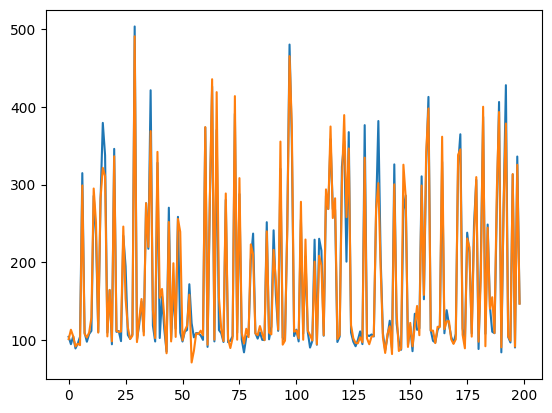

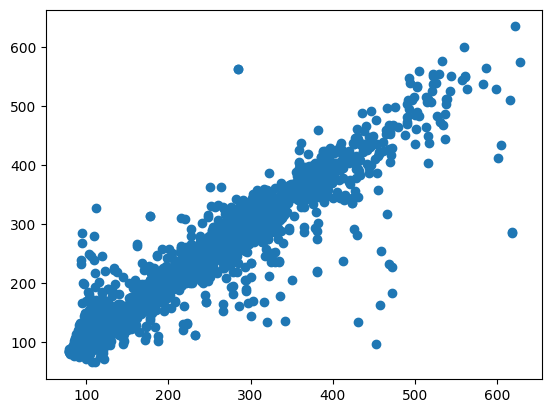

In [1513]:
from sklearn.neural_network import MLPRegressor

NN_model = MLPRegressor(hidden_layer_sizes=(100,100),max_iter=300)
NN_model.fit(X_train,y_train)
y_pred_NN = NN_model.predict(X_test)

plt.plot(np.arange(199),y_test[1:200])
plt.plot(np.arange(199),y_pred_NN[1:200])
plt.show()
plt.scatter(y_test,y_pred_NN)

In [1514]:
MAE_NN=metrics.mean_absolute_error(y_test,y_pred_NN)
MBE_NN=np.mean(y_test-y_pred_NN)
MSE_NN=metrics.mean_squared_error(y_test,y_pred_NN)
RMSE_NN= np.sqrt(metrics.mean_squared_error(y_test,y_pred_NN))
cvRMSE_NN=RMSE_NN/np.mean(y_test)
NMBE_NN=MBE_NN/np.mean(y_test)

print("MAE_NN: ")
print(MAE_NN)
print("MBE_NN: ")
print(MBE_NN)
print("MSE_NN: ")
print(MSE_NN)
print("RMSE_NN: ")
print(RMSE_NN)
print("cvRMSE_NN: ")
print(cvRMSE_NN)
print("NMBE_NN: ")
print(NMBE_NN)

MAE_NN: 
12.949690535659077
MBE_NN: 
0.21272540233498594
MSE_NN: 
752.8414788080455
RMSE_NN: 
27.437956899303664
cvRMSE_NN: 
0.15758358245447013
NMBE_NN: 
0.001221739326366036


# Model Selection


Looking for the metrics it's obvious to see that the better model was XGboost and Bootstraping. They have in general lower errors then the second best will be bootstraping, then random forest and then decision trees. In some metrics Boostraping is better and in others XGBoost is better. Meaning that it could be just a matter of preference. Since I am used to use XGBoost I will stick with it.

We could for each model try to standardize for each model the data or reduce the number of features but the amount of work would be huge and also it's obvious, not only because the evaluation metrics and plots, but for experience I know that the AR, LR, SVR, GPR and decisions trees are usually simpler models, that can not capture complex patterns, or are computationally expensive, ... On the other hand, Random Forest, XGBoost and Neural Networks, usually can capture this complex patterns better. Then Random Forest usually doesn't capture time dependencies well, so it is not ideal for time series. About bootstraping I usually don't like to use them because the model that it creates are independent and don't learn from each other. So, basically the best would be XGBoost. Even though NN are usually better for bigger datasets, it can perfom well, so we are going to try these 2 models with more detail. On the next table you can see a brief summary of these different models.

| Model  | Pros | Cons | Best For |
|------------|-----------|------------|-----------------------------|
| **DT** | - Simple and interpretable  <br> - Fast training | - Overfits easily  <br> - Poor generalization | Small datasets where interpretability is important. |
| **RF** | - Reduces overfitting  <br> - Handles nonlinear relationships well  <br> - Works well with tabular data | - Slower than a single Decision Tree  <br> - Harder to interpret | Medium-sized datasets with structured features. |
| **XGBoost** | - High accuracy for structured data  <br> - Handles missing values well  <br> - Scales well to large datasets  <br> - Faster than Random Forest | - Requires feature engineering (lag)  <br> - Hyperparameter tuning required | Best for large datasets (e.g., 2 years of hourly data). <br>Good balance of speed and accuracy. |
| **SVR** | - Works well for small datasets  <br> - Handles nonlinear relationships well  <br> - Robust to outliers | - Very slow for large datasets  <br> - Hard to tune (kernel, C, epsilon) | Small datasets with complex relationships. <br> Not scalable. |
| **GPR** |- Confidence intervals  <br> - Highly flexible and accurate | - Extremely slow for large datasets  <br> - Very memory-intensive  <br> - Hard to tune (kernel functions) | Small datasets where uncertainty estimation is important. |
| **NN** | - Captures deep patterns in data  <br> - Works well for large, complex datasets  <br> - Can learn long-term dependencies | - Requires a large amount of data  <br> - Computationally expensive  <br> - Hard to interpret | Large-scale datasets with complex relationships, <br>or when using deep learning (LSTMs, Transformers) <br>for time series. |


In [1616]:
merged_df = pd.read_csv(r'Power_Cleaned.csv')

merged_df = merged_df.set_index('Date_start') # make 'datetime' into index

merged_df.index = pd.to_datetime(merged_df.index)


merged_df.head()

Power_kW         HR  solarRad_W/m2  Weekday  Hour_sin  \
Date_start                                                                    
2017-01-01 00:00:00  80.047693  67.979167       1.100750        6  0.000000   
2017-01-01 01:00:00  81.376392  70.430000       0.941667        6  0.258819   
2017-01-01 02:00:00  79.450315  75.283333       0.734083        6  0.500000   
2017-01-01 03:00:00  78.523656  76.466667       1.237500        6  0.707107   
2017-01-01 04:00:00  78.947765  76.475000       1.288167        6  0.866025   

                     Hour_cos  Power_kW_lag_1h  Power_kW_lag_2h  \
Date_start                                                        
2017-01-01 00:00:00  1.000000        80.047693        80.047693   
2017-01-01 01:00:00  0.965926        80.047693        80.047693   
2017-01-01 02:00:00  0.866025        81.376392        80.047693   
2017-01-01 03:00:00  0.707107        79.450315        81.376392   
2017-01-01 04:00:00  0.500000        78.523656        79.450315   

                     Power_kW_lag_24h       HDH  CDH_squared  CDH_Humidity  \
Date_start                                                                   
2017-01-01 00:00:00         80.025188  4.313333          0.0           0.0   
2017-01-01 01:00:00         80.615793  4.760833          0.0           0.0   
2017-01-01 02:00:00         80.941577  5.264167          0.0           0.0   
2017-01-01 03:00:00         85.234447  5.255833          0.0           0.0   
2017-01-01 04:00:00         78.660000  4.987500          0.0           0.0   

                     log_temp  holiday  
Date_start                              
2017-01-01 00:00:00  2.458449     True  
2017-01-01 01:00:00  2.419405     True  
2017-01-01 02:00:00  2.373587     True  
2017-01-01 03:00:00  2.374363     True  
2017-01-01 04:00:00  2.399031     True

## XGBoost

Used Grid Search to find the best parameters but the default one were always the better so I sticked with the default paramters.

The part of finding the best parameters is comment to make it faster.

NOTE: Couldn't save the model using pickle, so I used joblib

MAE (Mean Absolute Error): 7.86
MBE (Mean Bias Error): 0.50
MSE (Mean Squared Error): 246.54
RMSE (Root Mean Squared Error): 15.70
cvRMSE (Coefficient of Variation RMSE): 8.94%
NMBE (Normalized Mean Bias Error): 0.29%
R² (Coefficient of Determination): 0.978


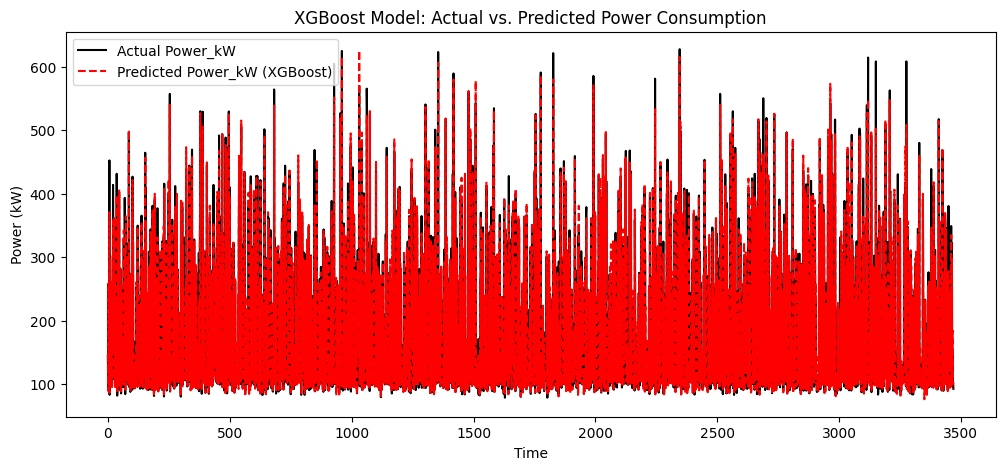

['XGB_model.sav']

In [1617]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping


# Define feature columns and target variable
features = merged_df.columns.drop(['Power_kW']).tolist()
target = "Power_kW"

# Split dataset into features (X) and target variable (y)
X = merged_df[features]
y = merged_df[target]


# Splitting data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
y_pred_XGB =xgb_model.predict(X_test)


# Compute all requested metrics
MAE_XGB = metrics.mean_absolute_error(y_test, y_pred_XGB)
MBE_XGB = np.mean(y_test - y_pred_XGB)
MSE_XGB = metrics.mean_squared_error(y_test, y_pred_XGB)
RMSE_XGB = np.sqrt(MSE_XGB)
cvRMSE_XGB = RMSE_XGB / np.mean(y_test)
NMBE_XGB = MBE_XGB / np.mean(y_test)
R2_XGB = metrics.r2_score(y_test, y_pred_XGB)

# Print all metrics
print(f"MAE (Mean Absolute Error): {MAE_XGB:.2f}")
print(f"MBE (Mean Bias Error): {MBE_XGB:.2f}")
print(f"MSE (Mean Squared Error): {MSE_XGB:.2f}")
print(f"RMSE (Root Mean Squared Error): {RMSE_XGB:.2f}")
print(f"cvRMSE (Coefficient of Variation RMSE): {cvRMSE_XGB:.2%}")
print(f"NMBE (Normalized Mean Bias Error): {NMBE_XGB:.2%}")
print(f"R² (Coefficient of Determination): {R2_XGB:.3f}")


plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Power_kW", color='black')
plt.plot(np.arange(len(y_test)), y_pred_XGB, label="Predicted Power_kW (XGBoost)", color='red', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("XGBoost Model: Actual vs. Predicted Power Consumption")
plt.legend()
plt.show()




import joblib
joblib.dump(xgb_model, 'XGB_model.sav')

In [1618]:
"""
xgb_default = XGBRegressor()
xgb_default.fit(X_train, y_train)
y_pred_default = xgb_default.predict(X_test)
default_mse = mean_squared_error(y_test, y_pred_default)

param_grid = {
    'n_estimators': [100, 150, 200],  # Default is 100, trying small variations
    'learning_rate': [0.1, 0.05, 0.2],  # Default is 0.1
    'max_depth': [3, 4, 5],  # Default is 3
    'subsample': [0.8, 1.0],  # Default is 1.0
    'colsample_bytree': [0.8, 1.0]  # Default is 1.0
}

xgb_tuned = XGBRegressor()
grid_search = GridSearchCV(xgb_tuned, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred_best)

if best_mse < default_mse:
    print("Tuned model performed better.")
    final_model = best_xgb
else:
    print("Default model performed better.")
    final_model = xgb_default

print("Default Model MSE:", default_mse)
print("Best Tuned Model MSE:", best_mse)
"""

'\nxgb_default = XGBRegressor()\nxgb_default.fit(X_train, y_train)\ny_pred_default = xgb_default.predict(X_test)\ndefault_mse = mean_squared_error(y_test, y_pred_default)\n\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],  # Default is 100, trying small variations\n    \'learning_rate\': [0.1, 0.05, 0.2],  # Default is 0.1\n    \'max_depth\': [3, 4, 5],  # Default is 3\n    \'subsample\': [0.8, 1.0],  # Default is 1.0\n    \'colsample_bytree\': [0.8, 1.0]  # Default is 1.0\n}\n\nxgb_tuned = XGBRegressor()\ngrid_search = GridSearchCV(xgb_tuned, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\nbest_xgb = grid_search.best_estimator_\ny_pred_best = best_xgb.predict(X_test)\nbest_mse = mean_squared_error(y_test, y_pred_best)\n\nif best_mse < default_mse:\n    print("Tuned model performed better.")\n    final_model = best_xgb\nelse:\n    print("Default model performed better.")\n    final_model = xgb_default\n\nprint("Default Model

## Neural Networks

Used 4 hidden layers (len(features) > 128 > 256 > 128 > 64 > 1). Used l2 regularization (1e-3), batch normalization and dropout (p=0.2) to avoid overfitting. Used a early stop of 20 epochs. Also used Adam Optimizer (momentum). I normalized the data because it gave me better results. Used batch size of 64 (tried 128 but got worst results). Plotted the train loss vs validation loss, and train loss > val loss, meaning that there are no overfitting. Then saved the model in pth. Didn't save the model in sav because i was getting problems on the test part. Since I couldn't fix it i used this method just for the NN, but it doesn't changes nothing.

NOTE: If you run in Colab you can use the GPU which makes it much faster.

['HR', 'solarRad_W/m2', 'Weekday', 'Hour_sin', 'Hour_cos', 'Power_kW_lag_1h', 'Power_kW_lag_2h', 'Power_kW_lag_24h', 'HDH', 'CDH_squared', 'CDH_Humidity', 'log_temp', 'holiday']
Power_kW


C:\Users\tomas\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.1717, Val Loss: 0.0928
Epoch [2/200], Train Loss: 0.1231, Val Loss: 0.0812
Epoch [3/200], Train Loss: 0.1257, Val Loss: 0.0832
Epoch [4/200], Train Loss: 0.1123, Val Loss: 0.0776
Epoch [5/200], Train Loss: 0.1006, Val Loss: 0.0797
Epoch [6/200], Train Loss: 0.1028, Val Loss: 0.0798
Epoch [7/200], Train Loss: 0.0951, Val Loss: 0.0776
Epoch [8/200], Train Loss: 0.0975, Val Loss: 0.0868
Epoch [9/200], Train Loss: 0.0925, Val Loss: 0.0664
Epoch [10/200], Train Loss: 0.0914, Val Loss: 0.0767
Epoch [11/200], Train Loss: 0.0944, Val Loss: 0.0711
Epoch [12/200], Train Loss: 0.0889, Val Loss: 0.0713
Epoch [13/200], Train Loss: 0.0927, Val Loss: 0.0756
Epoch [14/200], Train Loss: 0.0872, Val Loss: 0.0730
Epoch [15/200], Train Loss: 0.0850, Val Loss: 0.0667
Epoch [16/200], Train Loss: 0.0879, Val Loss: 0.0667
Epoch [17/200], Train Loss: 0.0832, Val Loss: 0.0676
Epoch [18/200], Train Loss: 0.0829, Val Loss: 0.0610
Epoch [19/200], Train Loss: 0.0870, Val Loss: 0.0631
Ep

C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\1832163364.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


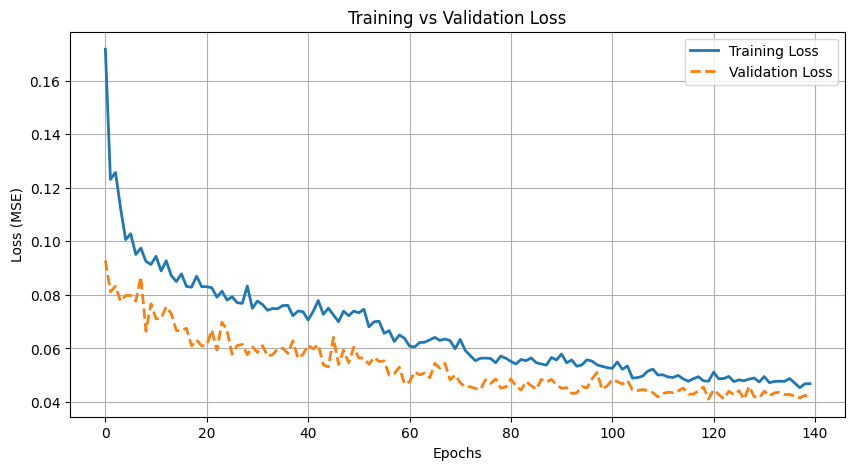

In [1619]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = merged_df.copy().dropna()

features = df.columns.drop(["Power_kW"]).tolist()
target = "Power_kW"


print(features)
print(target)


# normalize
scaler_x = MinMaxScaler()
df[features] = scaler_x.fit_transform(df[features])

scaler_y = StandardScaler()
df[target] = scaler_y.fit_transform(df[[target]])

# split training (70%), validation (15%), and test (15%)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# pytorch tensors
def prepare_tensor_data(data):
    X = torch.tensor(data[features].values, dtype=torch.float32)
    y = torch.tensor(data[target].values, dtype=torch.float32).view(-1, 1)
    return X, y

X_train, y_train = prepare_tensor_data(train_data)
X_val, y_val = prepare_tensor_data(val_data)
X_test, y_test = prepare_tensor_data(test_data)

# dataloaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

class EnergyPredictor(nn.Module):
    def __init__(self):
        super(EnergyPredictor, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# initialize model, loss function, and optimizer
model = EnergyPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# reduce learning rate to half if there is no improvement
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# early stopping
early_stop_patience = 20  # Stop training if no improvement for 20 epochs
best_val_loss = float('inf')
epochs_no_improve = 0



# trainning
num_epochs = 200
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # average training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # reduce eta if needed
    scheduler.step(val_loss)

    # early stopping check
    if val_loss - best_val_loss < -0.0005:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1

    # stop training if no improvement
    if epochs_no_improve >= early_stop_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")




# load the best model before evaluation
model.load_state_dict(torch.load("best_model.pth"))


# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", linewidth=2)
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", linestyle="dashed", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

# evaluate on test set
model.eval()
test_loss = 0.0
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        y_true.extend(y_batch.cpu().numpy().flatten())
        y_pred.extend(outputs.cpu().numpy().flatten())

# inverse transform predictions and actual values
y_true = scaler_y.inverse_transform([[y] for y in y_true])
y_pred = scaler_y.inverse_transform([[y] for y in y_pred])


y_true_orig = scaler_y.inverse_transform(np.array(y_true).reshape(-1, 1))
y_pred_orig = scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1))




MAE (Mean Absolute Error): 10.35
MBE (Mean Bias Error): -0.45
MSE (Mean Squared Error): 446.57
RMSE (Root Mean Squared Error): 21.13
cvRMSE (Coefficient of Variation RMSE): 11.98%
NMBE (Normalized Mean Bias Error): -0.26%
R² (Coefficient of Determination): 0.961


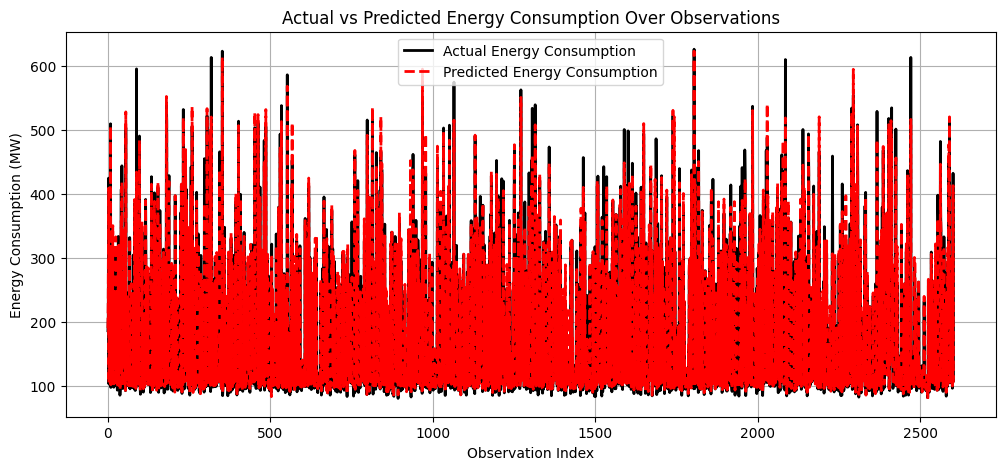

In [1620]:

#-------------------------
# Evaluation Metrics
#-------------------------


MAE_NN = metrics.mean_absolute_error(y_true, y_pred)
MBE_NN = np.mean(y_true - y_pred)
MSE_NN = metrics.mean_squared_error(y_true, y_pred)
RMSE_NN = np.sqrt(MSE_NN)
cvRMSE_NN = RMSE_NN / np.mean(y_true)
NMBE_NN = MBE_NN / np.mean(y_true)
R2_NN = metrics.r2_score(y_true, y_pred)

# Print all metrics
print(f"MAE (Mean Absolute Error): {MAE_NN:.2f}")
print(f"MBE (Mean Bias Error): {MBE_NN:.2f}")
print(f"MSE (Mean Squared Error): {MSE_NN:.2f}")
print(f"RMSE (Root Mean Squared Error): {RMSE_NN:.2f}")
print(f"cvRMSE (Coefficient of Variation RMSE): {cvRMSE_NN:.2%}")
print(f"NMBE (Normalized Mean Bias Error): {NMBE_NN:.2%}")
print(f"R² (Coefficient of Determination): {R2_NN:.3f}")



#-----------------------
# PLOTS
#-----------------------

plt.figure(figsize=(12, 5))
plt.plot(range(len(y_true)), y_true, label="Actual Energy Consumption", linewidth=2, color = "black")
plt.plot(range(len(y_pred)), y_pred, label="Predicted Energy Consumption", linestyle="dashed", linewidth=2, color = "red")
plt.xlabel("Observation Index")
plt.ylabel("Energy Consumption (MW)")
plt.title("Actual vs Predicted Energy Consumption Over Observations")
plt.legend()
plt.grid()
plt.show()


# Validation

## Data Preparation


In [1630]:
df_test = pd.read_csv('testData_2019_SouthTower.csv')

df_test['Date'] = pd.to_datetime(df_test['Date'])

df_test = df_test.set_index ('Date', drop = True) # changes the numbered indexes into the date


df_test.rename(columns={'South Tower (kWh)':'Power_kW'}, inplace=True)


df_test.head()


Power_kW     temp_C         HR  windSpeed_m/s  \
Date                                                                 
2019-01-01 00:00:00    88.677  10.635833  62.684167            0.0   
2019-01-01 01:00:00    87.990  10.377500  62.836667            0.0   
2019-01-01 02:00:00    94.752  10.260833  61.720000            0.0   
2019-01-01 03:00:00    88.709   9.666667  63.893333            0.0   
2019-01-01 04:00:00    88.926   8.640833  68.034167            0.0   

                     windGust_m/s    pres_mbar  solarRad_W/m2  rain_mm/h  \
Date                                                                       
2019-01-01 00:00:00           0.0  1031.000000       2.543250        0.0   
2019-01-01 01:00:00           0.0  1031.000000       1.728667        0.0   
2019-01-01 02:00:00           0.0  1031.083333       2.674750        0.0   
2019-01-01 03:00:00           0.0  1031.083333       2.444250        0.0   
2019-01-01 04:00:00           0.0  1031.000000       3.056333        0.0   

                     rain_day  
Date                           
2019-01-01 00:00:00       0.0  
2019-01-01 01:00:00       0.0  
2019-01-01 02:00:00       0.0  
2019-01-01 03:00:00       0.0  
2019-01-01 04:00:00       0.0

In [1631]:
is_ordered = df_test.index.is_monotonic_increasing
print(f"Is the index ordered? {is_ordered}")


duplicates = df_test[df_test.index.duplicated(keep=False)]
print("Repeated Dates:")
print(duplicates)

Is the index ordered? True
Repeated Dates:
Empty DataFrame
Columns: [Power_kW, temp_C, HR, windSpeed_m/s, windGust_m/s, pres_mbar, solarRad_W/m2, rain_mm/h, rain_day]
Index: []


In [1632]:
import pytz
df_test = df_test.drop(columns=['windSpeed_m/s',	'windGust_m/s',	'pres_mbar', 'rain_mm/h',	'rain_day'])



df_test["Hour"] = df_test.index.hour

df_test["Weekday"] = df_test.index.weekday  # 0 = Monday, 6 = Sunday


df_test["Hour_sin"] = np.sin(2 * np.pi * df_test["Hour"] / 24)
df_test["Hour_cos"] = np.cos(2 * np.pi * df_test["Hour"] / 24)

df_test["Power_kW_lag_1h"] = df_test["Power_kW"].shift(1)
df_test["Power_kW_lag_2h"] = df_test["Power_kW"].shift(2)
df_test["Power_kW_lag_24h"] = df_test["Power_kW"].shift(24)

df_test["HDH"] = np.maximum(0,-df_test["temp_C"]+16) # heating degree hours
df_test["CDH"] = np.maximum(0, df_test["temp_C"] - 25) # Coling degree hours


df_test["CDH_squared"] = df_test["CDH"] ** 2 # squared of CDH


df_test["CDH_Humidity"] = df_test["CDH"] * df_test["HR"] # try relationship with humidity

df_test["log_temp"] = np.log(df_test["temp_C"])


holidays = {
    1: {"2019-1-1"},
    2 : {"2019-2-6", "2019-2-17"},
    3 : {"2019-3-4","2019-3-5"},
    4 : {"2019-4-15","2019-4-19"},
    5 : {"2019-4-25"},
    6 : {"2019-5-1"},
    7 : {"2019-6-10"},
    8 : {"2019-6-13"},
    9 : {"2019-6-20"},
    10 : {"2019-7-27","2019-9-8"},
    11 : {"2019-7-27","2019-9-8"},
    12 : {"2019-12-21","2019-12-31"},
    13 : {"2019-10-5"},
    14 : {"2019-11-1"},
    15 : {"2019-12-1"},
    16 : {"2019-12-8"}
}

def expand_holiday_dates(holidays):
    expanded_dates = set()
    
    for dates_set in holidays.values():
        date_list = sorted(pd.to_datetime(list(dates_set)))  # Convert to datetime and sort
        
        if len(date_list) == 1: 
            expanded_dates.add(date_list[0].date())
        elif len(date_list) == 2: 
            expanded_dates.update(pd.date_range(date_list[0], date_list[1]).date)  # Expand range
    
    return expanded_dates

holiday_dates = expand_holiday_dates(holidays)


df_test['holiday'] = df_test.index.to_series().apply(lambda x: x.date()).isin(holiday_dates)


df_test = df_test.drop(columns = ['Hour','CDH','temp_C'])

df_test.info()




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2415 entries, 2019-01-01 00:00:00 to 2019-04-11 15:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Power_kW          2415 non-null   float64
 1   HR                2415 non-null   float64
 2   solarRad_W/m2     2415 non-null   float64
 3   Weekday           2415 non-null   int32  
 4   Hour_sin          2415 non-null   float64
 5   Hour_cos          2415 non-null   float64
 6   Power_kW_lag_1h   2414 non-null   float64
 7   Power_kW_lag_2h   2413 non-null   float64
 8   Power_kW_lag_24h  2391 non-null   float64
 9   HDH               2415 non-null   float64
 10  CDH_squared       2415 non-null   float64
 11  CDH_Humidity      2415 non-null   float64
 12  log_temp          2415 non-null   float64
 13  holiday           2415 non-null   bool   
dtypes: bool(1), float64(12), int32(1)
memory usage: 257.1 KB


In [1633]:
df_test["Power_kW_lag_1h"] = df_test["Power_kW_lag_1h"].interpolate(method='linear', limit_direction='both')
df_test["Power_kW_lag_2h"] = df_test["Power_kW_lag_2h"].interpolate(method='linear', limit_direction='both')

df_test["Power_kW_lag_24h"] = df_test["Power_kW_lag_24h"].fillna(df_test["Power_kW"].shift(-24))

df_test = df_test[df_test["Power_kW"] != 0]

print(df_test.info())

df_test.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2362 entries, 2019-01-01 00:00:00 to 2019-04-11 15:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Power_kW          2362 non-null   float64
 1   HR                2362 non-null   float64
 2   solarRad_W/m2     2362 non-null   float64
 3   Weekday           2362 non-null   int32  
 4   Hour_sin          2362 non-null   float64
 5   Hour_cos          2362 non-null   float64
 6   Power_kW_lag_1h   2362 non-null   float64
 7   Power_kW_lag_2h   2362 non-null   float64
 8   Power_kW_lag_24h  2362 non-null   float64
 9   HDH               2362 non-null   float64
 10  CDH_squared       2362 non-null   float64
 11  CDH_Humidity      2362 non-null   float64
 12  log_temp          2362 non-null   float64
 13  holiday           2362 non-null   bool   
dtypes: bool(1), float64(12), int32(1)
memory usage: 251.4 KB
None


Power_kW         HR  solarRad_W/m2  Weekday  Hour_sin  \
Date                                                                         
2019-01-01 00:00:00    88.677  62.684167       2.543250        1  0.000000   
2019-01-01 01:00:00    87.990  62.836667       1.728667        1  0.258819   
2019-01-01 02:00:00    94.752  61.720000       2.674750        1  0.500000   
2019-01-01 03:00:00    88.709  63.893333       2.444250        1  0.707107   
2019-01-01 04:00:00    88.926  68.034167       3.056333        1  0.866025   

                     Hour_cos  Power_kW_lag_1h  Power_kW_lag_2h  \
Date                                                              
2019-01-01 00:00:00  1.000000           88.677           88.677   
2019-01-01 01:00:00  0.965926           88.677           88.677   
2019-01-01 02:00:00  0.866025           87.990           88.677   
2019-01-01 03:00:00  0.707107           94.752           87.990   
2019-01-01 04:00:00  0.500000           88.709           94.752   

                     Power_kW_lag_24h       HDH  CDH_squared  CDH_Humidity  \
Date                                                                         
2019-01-01 00:00:00           108.261  5.364167          0.0           0.0   
2019-01-01 01:00:00           105.474  5.622500          0.0           0.0   
2019-01-01 02:00:00           107.180  5.739167          0.0           0.0   
2019-01-01 03:00:00           107.636  6.333333          0.0           0.0   
2019-01-01 04:00:00           105.547  7.359167          0.0           0.0   

                     log_temp  holiday  
Date                                    
2019-01-01 00:00:00  2.364229     True  
2019-01-01 01:00:00  2.339640     True  
2019-01-01 02:00:00  2.328334     True  
2019-01-01 03:00:00  2.268684     True  
2019-01-01 04:00:00  2.156499     True

## XGBoost

In [1635]:
XGB_model = joblib.load('XGB_model.sav')
print(XGB_model)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


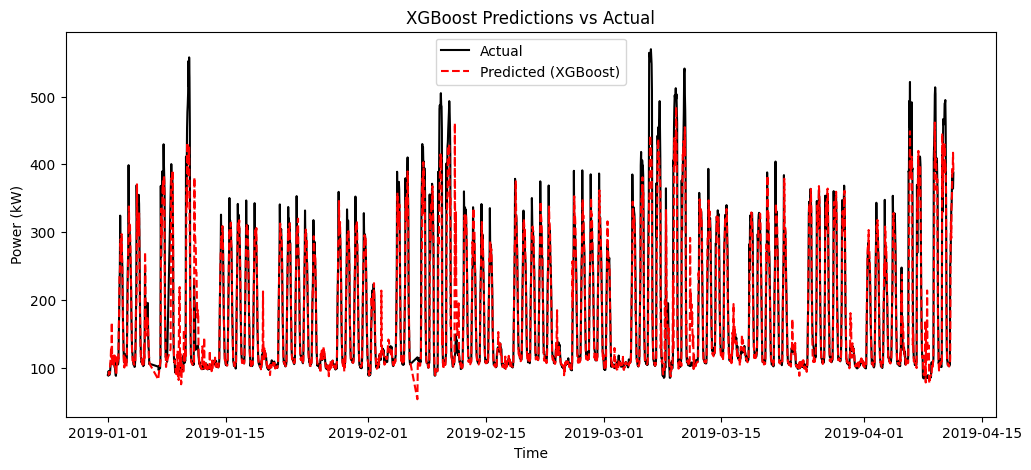

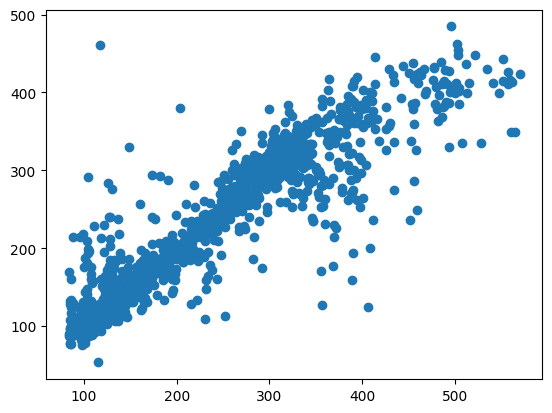

MAE (Mean Absolute Error): 16.76
MBE (Mean Bias Error): 5.00
MSE (Mean Squared Error): 1210.94
RMSE (Root Mean Squared Error): 34.80
cvRMSE (Coefficient of Variation RMSE): 19.02%
NMBE (Normalized Mean Bias Error): 2.73%
R² (Coefficient of Determination): 0.891


In [1636]:
y_pred2019_XGB = XGB_model.predict(df_test.drop(columns = ['Power_kW']))


plt.figure(figsize=(12,5))
plt.plot(df_test.index, df_test["Power_kW"], label="Actual", color="black")
plt.plot(df_test.index, y_pred2019_XGB, label="Predicted (XGBoost)", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("XGBoost Predictions vs Actual")
plt.legend()
plt.show()


plt.scatter(df_test['Power_kW'],y_pred2019_XGB)
plt.show()


MAE_XGB = metrics.mean_absolute_error(df_test["Power_kW"], y_pred2019_XGB)
MBE_XGB = np.mean(df_test["Power_kW"] - y_pred2019_XGB)
MSE_XGB = metrics.mean_squared_error(df_test["Power_kW"], y_pred2019_XGB)
RMSE_XGB = np.sqrt(MSE_XGB)
cvRMSE_XGB = RMSE_XGB / np.mean(df_test["Power_kW"])
NMBE_XGB = MBE_XGB / np.mean(df_test["Power_kW"])
R2_XGB = metrics.r2_score(df_test["Power_kW"], y_pred2019_XGB)

print(f"MAE (Mean Absolute Error): {MAE_XGB:.2f}")
print(f"MBE (Mean Bias Error): {MBE_XGB:.2f}")
print(f"MSE (Mean Squared Error): {MSE_XGB:.2f}")
print(f"RMSE (Root Mean Squared Error): {RMSE_XGB:.2f}")
print(f"cvRMSE (Coefficient of Variation RMSE): {cvRMSE_XGB:.2%}")
print(f"NMBE (Normalized Mean Bias Error): {NMBE_XGB:.2%}")
print(f"R² (Coefficient of Determination): {R2_XGB:.3f}")


## NN

In [1637]:
loaded_model = EnergyPredictor()

loaded_model.load_state_dict(torch.load("best_model.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

loaded_model.eval()


C:\Users\tomas\AppData\Local\Temp\ipykernel_20656\2650023357.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("best_model.pth"))


EnergyPredictor(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

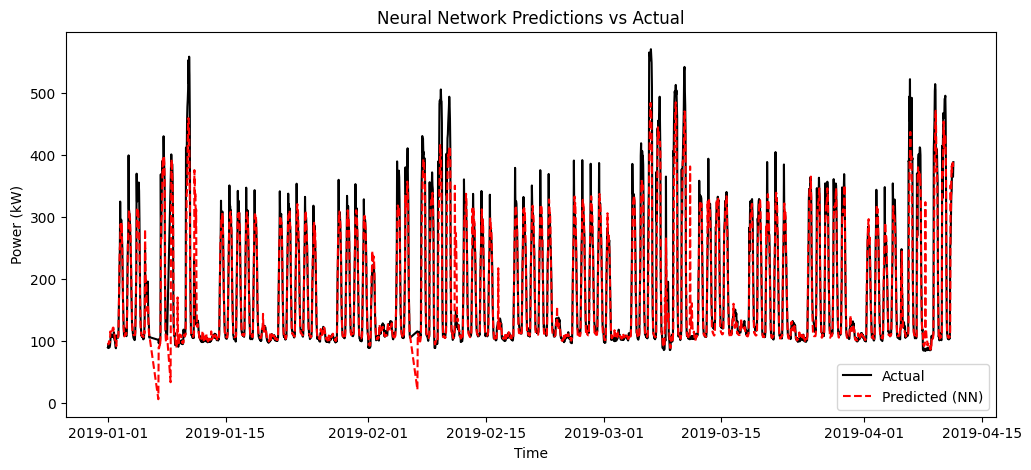

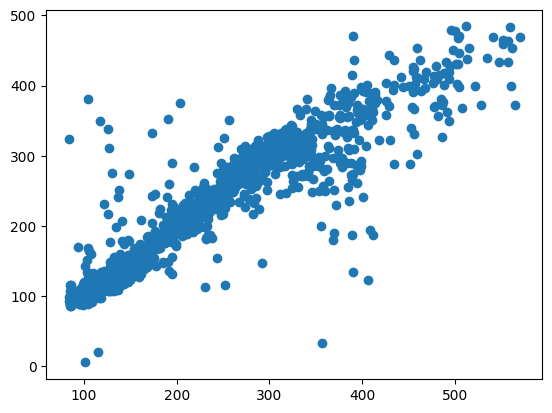

MAE (Mean Absolute Error): 15.36
MBE (Mean Bias Error): 5.71
MSE (Mean Squared Error): 1084.24
RMSE (Root Mean Squared Error): 32.93
cvRMSE (Coefficient of Variation RMSE): 17.99%
NMBE (Normalized Mean Bias Error): 3.12%
R² (Coefficient of Determination): 0.902


In [1638]:
df_test_cleaned = df_test.copy()

df_test_cleaned["holiday"] = df_test_cleaned["holiday"].astype(int)

df_test_cleaned[features] = scaler_x.transform(df_test_cleaned[features])

X_test_tensor = torch.tensor(df_test_cleaned[features].values, dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred_NN = loaded_model(X_test_tensor)

y_pred_NN = y_pred_NN.cpu().numpy()

y_pred_NN_orig = scaler_y.inverse_transform(y_pred_NN)


plt.figure(figsize=(12,5))
plt.plot(df_test.index, df_test["Power_kW"], label="Actual", color="black")
plt.plot(df_test.index, y_pred_NN_orig, label="Predicted (NN)", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Neural Network Predictions vs Actual")
plt.legend()
plt.show()


plt.scatter(df_test['Power_kW'],y_pred_NN_orig)
plt.show()



y_pred_NN_orig = y_pred_NN_orig.reshape(-1,)

MAE_NN = metrics.mean_absolute_error(df_test["Power_kW"], y_pred_NN_orig)
MBE_NN = np.mean(df_test["Power_kW"] - y_pred_NN_orig)
MSE_NN = metrics.mean_squared_error(df_test["Power_kW"], y_pred_NN_orig)
RMSE_NN = np.sqrt(MSE_NN)
cvRMSE_NN = RMSE_NN / np.mean(df_test["Power_kW"])
NMBE_NN = MBE_NN / np.mean(df_test["Power_kW"])
R2_NN = metrics.r2_score(df_test["Power_kW"], y_pred_NN_orig)

print(f"MAE (Mean Absolute Error): {MAE_NN:.2f}")
print(f"MBE (Mean Bias Error): {MBE_NN:.2f}")
print(f"MSE (Mean Squared Error): {MSE_NN:.2f}")
print(f"RMSE (Root Mean Squared Error): {RMSE_NN:.2f}")
print(f"cvRMSE (Coefficient of Variation RMSE): {cvRMSE_NN:.2%}")
print(f"NMBE (Normalized Mean Bias Error): {NMBE_NN:.2%}")
print(f"R² (Coefficient of Determination): {R2_NN:.3f}")


# Conclusion

We got fairly good results. Usually a good rule is models with $R^2 > 0.85$ are considered good and models with $R^2 > 0.90$ excelent models. We got near that. Having in mind that the test data had some power values with 0, that were obviously outliers, made the model, as we can see in the plots, predict it wrongly. One of the reasons is because the model depends heavily on the lag features. Maybe without those zeros it would reach in both cases the goal of $R^2>0.90$. 

Talking about the other metrics, we see that MSE and RMSE are high meaning that the squared error was big. On the other hand we got a MAE error of of ~16kW that isn't that big when comparing with the values that we got (for example big part of the data has power > 300kW, meaning that the MAE is around 5% of this values).

With MBE positive means that i am overestimating the power consumption by an average of ~6kW on NN and ~3kW on XGBoost.

For the cvRMSE usually models <10% are considered very good models. We got ~18% meaning that it is an acceptable model.

Overall, both models are really close to each other, one being better in some metrics then the other and vice-versa.

